In [1]:
import numpy as np
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
import warnings, os, gc, joblib
import lightgbm as lgb
from sklearn import metrics
from functools import reduce
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, classification_report, RocCurveDisplay
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, StratifiedGroupKFold
from contextlib import suppress
import catboost
from catboost import CatBoostClassifier, Pool
import xgboost as xgb

In [2]:
pathway = "/kaggle/input/home-credit-credit-risk-model-stability/"

### Набор пользовательских функций, которые помогут в предварительной обработке данных:

In [3]:
def set_table_dtypes(df: pl.DataFrame) -> pl.DataFrame:
    '''Принимает фрейм данных в качестве входных данных и перебирает все столбцы
       Каждый столбец заканчивается на P или A, приводит столбец к Float 64'''
    for col in df.columns:
        # Преобразует DPD (дни просрочки платежа) и A (сумму) как тип Float64.
        if col[-1] in ("P", "A"):
            df = df.with_columns(pl.col(col).cast(pl.Float64).alias(col))
        # Приодит агрегированные числовые столбцы к типу Float64
        if col[-4:-1] in ('_sum'):
            df = df.with_columns(pl.col(col).cast(pl.Float64).alias(col))
        if col[-4:-1] in ('_max'):
            df = df.with_columns(pl.col(col).cast(pl.Float64).alias(col))
    return df


def convert_strings(df: pl.DataFrame) -> pl.DataFrame:
    '''Принимает фрейм данных в качестве входных данных и перебирает все столбцы
       Каждый столбец, который является строкой или объектом он преобразует столбец в строковый тип, а затем в тип cat'''
    for col in df.columns:
        if df[col].dtype == pl.Utf8:
            df = df.with_columns(pl.col(col).cast(pl.Categorical))
    return df



def missing_values(df, threshold = 0.9):
    '''выводит процент пропущенных значений'''
    for col in df.columns:
        decimal = (pd.isnull(test[col]).sum())/(len(test[col]))
        if decimal > threshold:
            print(f"{col}: {decimal}")
            


def imputer(df:pd.DataFrame) -> pd.DataFrame:
    '''обозначает числовые колонки со средним значением и cat с режимом'''
    for col in df.columns:
        if df[col].dtype in ['float64']:
            df[col] = df[col].fillna(df[col].median())
        if df[col].dtype.name in ['category', 'object'] and df[col].isull().any():
            model_without_nan = df[col].dropna().mode().values[0] #представляет наиболее частое значение в столбце, исключая любые недостающие значения
            df[col] = df[col].fillna(model_without_nan)
    return df



def custom_range_agg(series: pl.series):
    '''принимает ряд в качестве входного и вычисляет диапазон (разница между максимальными и минимальными значениями в серии)'''
    custom_range = series.max() - series.min()
    return custom_range



def compare_cols(df):
    '''Используется для сравнения агрегированных функций суммы и диапазона друг против друга, печатая процент столбца диапазона, который либо равен 0, либо значение столбца суммы'''
    range_list = [element for e in df.columns for element in e.split() if element.endswith("_range")]
    sum_list = [name.replace('range', 'sum') for name in range_list]
    length = len(df)
    
    df=df.with_columns(*[pl.col(col).fill_null(strategy='zero') for col in range_list])
    
    for i in range(len(range_list)):
        df = df.with_columns(check=pl.when((df[range_list[i]] == df[sum_list[i]]) | (df[range_list[i]] == 0)).then(1).otherwise(0))
        percent = df.select(pl.sum("check")).item() / length
        print(f"Percent equal or 0 for {range_list[i]} = {percent:.3f}")
        
    df = df.drop("check")
    return df



def reduce_mem_usage(df):
    '''Уменьшит использование памяти датафрамы. Все числовые столбцы будут отображаться в нижнем диапазоне столбцов'''
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        if str(col_type)=="category":
            continue
            
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
                    
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
                    
        else:
            continue
    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

### Создание совместных тестовых данных


### Part 1

Обработка тренировочного файла. Отбрасываемые столбцы вручную отбираются из того, что было выброшено на тренировке, исходя из избыточных недостающих значений. Мы использовали . drop(errors='ignore') для обработки ситуаций, когда скрытый тестовый набор имел разные столбцы.

In [4]:
test_basetable = pl.read_csv(pathway + "csv_files/test/test_base.csv")
test_static = pl.concat(
    [pl.read_csv(pathway + "csv_files/test/test_static_0_0.csv").pipe(set_table_dtypes),
    pl.read_csv(pathway + "csv_files/test/test_static_0_1.csv").pipe(set_table_dtypes),
    pl.read_csv(pathway + "csv_files/test/test_static_0_2.csv").pipe(set_table_dtypes)], how="vertical_relaxed")
test_static_cb=pl.read_csv(pathway + "csv_files/test/test_static_cb_0.csv").pipe(set_table_dtypes)
test_person_1=pl.read_csv(pathway + "csv_files/test/test_person_1.csv").pipe(set_table_dtypes)
test_credit_bureau_b_2=pl.read_csv(pathway + "csv_files/test/test_credit_bureau_b_2.csv").pipe(set_table_dtypes)

In [5]:
# additional depth = 1 files

test_other_1 = pl.read_csv(pathway + "csv_files/test/test_other_1.csv").pipe(set_table_dtypes)

test_credit_bureau_b_1 = pl.read_csv(pathway + "csv_files/test/test_credit_bureau_b_1.csv").pipe(set_table_dtypes)

test_deposit_1 = pl.read_csv(pathway + "csv_files/test/test_deposit_1.csv").pipe(set_table_dtypes)

test_basetable = test_basetable.with_columns(pl.col('date_decision').cast(pl.Date))

In [6]:
test_person_1_feats_1 = test_person_1.group_by("case_id").agg(
    pl.col("mainoccupationinc_384A").sum().alias("mainoccupationinc_384A_sum"))

#num_group1=0 представляет лицо, обратившееся за кредитом
test_person_1_feats_2 = test_person_1.select(["case_id", "num_group1", "incometype_1044T", "birth_259D",
    "empl_employedfrom_271D","empl_industry_691L","familystate_447L","sex_738L","type_25L",
    "safeguarantyflag_411L","empl_employedtotal_800L","role_1084L"]).filter(
    pl.col("num_group1")==0).drop("num_group1")

test_credit_bureau_b_2_feats = test_credit_bureau_b_2.group_by("case_id").agg(
    pl.col("pmts_pmtsoverdue_635A").sum().alias("pmts_pmtsoverdue_635A_sum"),
    pl.col("pmts_dpdvalue_108P").sum().alias("pmts_dpdvalue_108P_sum"))

In [7]:
"""
# use aggregation functions in tables with depth >=1
#this code cell commented out because error somewhere

test_person_1_feats_1 = test_person_1.group_by("case_id").agg(
    pl.col("mainoccupationinc_384A").sum().alias("mainoccupationinc_384A_sum"))

#num_group1=0 represents the person who originally applied for the loan
test_person_1_feats_2 = test_person_1.select(["case_id", "num_group1", "incometype_1044T", "birth_259D", "empl_employedfrom_271D", "empl_industry_691L", "familystate_447L", "sex_738L", "type_25L",
                                             "safeguarantyflag_411L", "empl_employedtotal_800L", "role_1084L"]).filter(pl.col("num_group1")==0).drop("num_group1")

#we now have num_group1 and num_group2, so aggregate again
test_credit_bureau_b_2_feats = test_credit_bureau_b_2.group_by("case_id").agg(
    pl.col("pmts_pmtsoverdue_635A").sum().alias("pmts_pmtsoverdue_635A_sum"),
    pl.col("pmts_dpdvalue_108P").sum().alias("pmts_dpdvalue_108P_sum"))

"""

'\n# use aggregation functions in tables with depth >=1\n#this code cell commented out because error somewhere\n\ntest_person_1_feats_1 = test_person_1.group_by("case_id").agg(\n    pl.col("mainoccupationinc_384A").sum().alias("mainoccupationinc_384A_sum"))\n\n#num_group1=0 represents the person who originally applied for the loan\ntest_person_1_feats_2 = test_person_1.select(["case_id", "num_group1", "incometype_1044T", "birth_259D", "empl_employedfrom_271D", "empl_industry_691L", "familystate_447L", "sex_738L", "type_25L",\n                                             "safeguarantyflag_411L", "empl_employedtotal_800L", "role_1084L"]).filter(pl.col("num_group1")==0).drop("num_group1")\n\n#we now have num_group1 and num_group2, so aggregate again\ntest_credit_bureau_b_2_feats = test_credit_bureau_b_2.group_by("case_id").agg(\n    pl.col("pmts_pmtsoverdue_635A").sum().alias("pmts_pmtsoverdue_635A_sum"),\n    pl.col("pmts_dpdvalue_108P").sum().alias("pmts_dpdvalue_108P_sum"))\n\n'

In [8]:
# Дополнительная агрегация для файлов глубины=1
test_other_1_feats = test_other_1.group_by("case_id").agg(
    pl.col("amtdebitincoming_4809443A").sum().alias("amtdebitincoming_4809443A_sum"),
    pl.col("amtdebitoutgoing_4809440A").sum().alias("amtdebitoutgoing_4809440A_sum"),
    pl.col("amtdepositbalance_4809441A").sum().alias("amtdepositbalance_4809441A_sum"),
    pl.col("amtdepositincoming_4809444A").sum().alias("amtdepositincoming_4809444A_sum"),
    pl.col("amtdepositoutgoing_4809442A").sum().alias("amtdepositoutgoing_4809442A_sum"))

test_credit_bureau_b_1_feats = test_credit_bureau_b_1.group_by("case_id").agg(
    pl.col("amount_1115A").sum().alias("amount_1115A_sum"),
    pl.col("credquantity_1099L").sum().alias("credquantity_1099L_sum"),
    pl.col("credquantity_984L").sum().alias("credquantity_984L_sum"),
    pl.col("debtpastduevalue_732A").sum().alias("debtpastduevalue_732A_sum"),
    pl.col("debtvalue_227A").sum().alias("debtvalue_227A_sum"),
    pl.col("dpd_550P").sum().alias("dpd_550P_sum"),
    pl.col("dpd_733P").sum().alias("dpd_733P_sum"),
    pl.col("dpdmax_851P").max().alias("dpdmax_851P_max"),
    pl.col("installmentamount_644A").sum().alias("installmentamount_644A_sum"),
    pl.col("installmentamount_833A").sum().alias("installmentamount_833A_sum"),
    pl.col("instlamount_892A").sum().alias("instlamount_892A_sum"),
    pl.col("interestrateyearly_538L").max().alias("interestrateyearly_538L_max"),
    pl.col("maxdebtpduevalodued_3940955A").max().alias("maxdebtpduevalodued_3940955A_max"),
    pl.col("numberofinstls_810L").sum().alias("numberofinstls_810L_sum"),
    pl.col("overdueamountmax_950A").max().alias("overdueamountmax_950A_max"),
    pl.col("pmtdaysoverdue_1135P").sum().alias("pmtdaysoverdue_1135P_sum"),
    pl.col("pmtnumpending_403L").sum().alias("pmtnumpending_403L_sum"),
    pl.col("residualamount_3940956A").sum().alias("residualamount_3940956A_sum"),
    pl.col("totalamount_503A").sum().alias("totalamount_503A_sum"), 
    pl.col("totalamount_881A").sum().alias("totalamount_881A_sum"))

test_deposit_1_feats = test_deposit_1.group_by("case_id").agg(
    pl.col("amount_416A").sum().alias("amount_416A_sum"))

In [9]:
"""
# additional aggregation for depth = 1 files
#commented this out because error

test_other_1_feats = test_other_1.group_by("case_id").agg(
    pl.col("amtdebitincoming_4809443A").sum().alias("amtdebitincoming_4809443A_sum"),
    pl.col("amtdebitoutgoing_4809440A").sum().alias("amtdebitoutgoing_4809440A_sum"),
    pl.col("amtdepositbalance_4809441A").sum().alias("amtdepositbalance_4809441A_sum"),
    pl.col("amtdepositincoming_4809444A").sum().alias("amtdepositincoming_4809444A_sum"),
    pl.col("amtdepositoutgoing_4809442A").sum().alias("amtdepositougoing_4809442A_sum"))

test_credit_bureau_b_1_feats = test_credit_bureau_b_1.group_by("case_id").agg(
    pl.col("amount_1115A").sum().alias("amount_1115A_sum"),
    pl.col("credquantity_1099L").sum().alias("credquantity_1099L_sum"),
    pl.col("credquantity_984L").sum().alias("credquantity_984L_sum"),
    pl.col("debtpastduevalue_732A").sum().alias("debtpastduevalue_732_sum"),
    pl.col("debtvalue_227A").sum().alias("debtvalue_227A_sum"),
    pl.col("dpd_550P").sum().alias("dpd_550P_sum"),
    pl.col("dpd_733P").sum().alias("dpd_733P_sum"),
    pl.col("dpdmax_851P").max().alias("dpdmax_851P_max"),
    pl.col("installmentamount_644A").sum().alias("installmentamount_644A_sum"),
    pl.col("installmentamount_833A").sum().alias("installmentamount_833A_sum"),
    pl.col("instlamount_892A").sum().alias("instlamount_892A_sum"),
    pl.col("interestrateyearly_538L").max().alias("interestrateyearly_538L_max"),
    pl.col("maxdebtpduevalodued_3940955A").max().alias("maxdebtpduevalodued_3940955A_max"),
    pl.col("numberofinstls_810L").sum().alias("numberofinstls_810L_sum"),
    pl.col("overdueamountmax_950A").max().alias("overdueamountmax_950A_max"),
    pl.col("pmtdaysoverdue_1135P").sum().alias("pmtdaysoverdue_1135P_sum"),
    pl.col("pmtnumpending_403L").sum().alias("pmtnumpending_403L_sum"),
    pl.col("residualamount_3940956A").sum().alias("residualamount_3940956A_sum"),
    pl.col("totalamount_503A").sum().alias("totalamount_503A_sum"),
    pl.col("totalamount_881A").sum().alias("totalamount_881A_sum"))

test_deposit_1_feats = test_deposit_1.group_by("case_id").agg(
    pl.col("amount_416A").sum().alias("amount_416A_sum"))
    
"""

'\n# additional aggregation for depth = 1 files\n#commented this out because error\n\ntest_other_1_feats = test_other_1.group_by("case_id").agg(\n    pl.col("amtdebitincoming_4809443A").sum().alias("amtdebitincoming_4809443A_sum"),\n    pl.col("amtdebitoutgoing_4809440A").sum().alias("amtdebitoutgoing_4809440A_sum"),\n    pl.col("amtdepositbalance_4809441A").sum().alias("amtdepositbalance_4809441A_sum"),\n    pl.col("amtdepositincoming_4809444A").sum().alias("amtdepositincoming_4809444A_sum"),\n    pl.col("amtdepositoutgoing_4809442A").sum().alias("amtdepositougoing_4809442A_sum"))\n\ntest_credit_bureau_b_1_feats = test_credit_bureau_b_1.group_by("case_id").agg(\n    pl.col("amount_1115A").sum().alias("amount_1115A_sum"),\n    pl.col("credquantity_1099L").sum().alias("credquantity_1099L_sum"),\n    pl.col("credquantity_984L").sum().alias("credquantity_984L_sum"),\n    pl.col("debtpastduevalue_732A").sum().alias("debtpastduevalue_732_sum"),\n    pl.col("debtvalue_227A").sum().alias("deb

In [10]:
# соединять все таблицы/столбцы вместе

join_data1 = test_basetable.join(test_static, how="left", on="case_id"
).join(test_static_cb, how="left", on="case_id"
).join(test_person_1_feats_1, how="left", on="case_id"
).join(test_person_1_feats_2, how="left", on="case_id"
).join(test_credit_bureau_b_2_feats, how="left", on="case_id"
).join(test_other_1_feats, how="left", on="case_id"
).join(test_credit_bureau_b_1_feats, how="left", on="case_id"
).join(test_deposit_1_feats, how="left", on="case_id"
)

In [11]:
"""
#after merge, convert back to pandas for errors = 'ignore' functionality

join_data1 = join_data1.to_pandas()

drop_cols = ['clientscnt_136L', 'datelastinstal40dpd_247D', 'equalitydataagreement_891L', 'equalityempfrom_62L', 'interestrategrace_34L', 'isbidproductrequest_292L', 'lastdependentsnum_448L',
            'lastotherinc_902A', 'lastotherlnsexpense_631A', 'lastrepayingdate_696D', 'maxannuity_4075009A', 'payvacationpostpone_4187118D', 'validfrom_1069D', 'assignmentdate_238D',
            'assignmentdate_4527235D', 'assignmentdate_4955616D', 'dateofbirth_342D', 'for3years_128L', 'for3years_504L', 'for3years_584L', 'formonth_118L', 'formonth_206L', 'formonth_535L', 'forquarter_1017L',
            'forquarter_462L', 'forquarter_634L', 'fortoday_1092L', 'forweek_1077L', 'forweek_528L', 'forweek_601L', 'foryear_618L', 'foryear_818L', 'foryear_850L', 'pmtaverage_3A', 'pmtaverage_4527227A',
            'pmtaverage_4955615A', 'pmtcount_4527229L', 'pmtcount_4955617L', 'pmtcount_693L', 'riskassessment_302T', 'riskassessment_940T', 'pmts_pmtsoverdue_635A_sum', 'pmts_dpdvalue_108P_sum',
            'amtdebitincoming_4809443A_sum', 'amtdebitoutgoing_4809440A_sum', 'amtdepositbalance_4809441A_sum', 'amtdepositincoming_4809444A_sum', 'amtdepositoutgoing_4809442A_sum', 'amount_1115A_sum',
            'credquantity_1099L_sum', 'credquantity_984L_sum', 'debtpastduevalue_732A_sum', 'debtvalue_227A_sum', 'dpd_550P_sum', 'dpd_733P_sum', 'dpdmax_851P_max', 'installmentamount_644A_sum',
            'installmentamount_833A_sum', 'instlamount_892A_sum', 'interestrateyearly_538L_max', 'maxdebtpduevalodued_3940955A_max', 'numberofinstls_810L_sum', 'overdueamountmax_950A_max', 'pmtdaysoverdue_1135P_sum',
            'pmtnumpending_403L_sum', 'residualamount_3940956A_sum', 'totalamount_503A_sum', 'totalamount_881A_sum', 'amount_416A_sum']

join_data1 = join_data1.drop(drop_cols, axis=1, errors="ignore")
join_data1.shape

"""

'\n#after merge, convert back to pandas for errors = \'ignore\' functionality\n\njoin_data1 = join_data1.to_pandas()\n\ndrop_cols = [\'clientscnt_136L\', \'datelastinstal40dpd_247D\', \'equalitydataagreement_891L\', \'equalityempfrom_62L\', \'interestrategrace_34L\', \'isbidproductrequest_292L\', \'lastdependentsnum_448L\',\n            \'lastotherinc_902A\', \'lastotherlnsexpense_631A\', \'lastrepayingdate_696D\', \'maxannuity_4075009A\', \'payvacationpostpone_4187118D\', \'validfrom_1069D\', \'assignmentdate_238D\',\n            \'assignmentdate_4527235D\', \'assignmentdate_4955616D\', \'dateofbirth_342D\', \'for3years_128L\', \'for3years_504L\', \'for3years_584L\', \'formonth_118L\', \'formonth_206L\', \'formonth_535L\', \'forquarter_1017L\',\n            \'forquarter_462L\', \'forquarter_634L\', \'fortoday_1092L\', \'forweek_1077L\', \'forweek_528L\', \'forweek_601L\', \'foryear_618L\', \'foryear_818L\', \'foryear_850L\', \'pmtaverage_3A\', \'pmtaverage_4527227A\',\n            \'p

In [12]:
# После слияния преобразовать обратно в pandas
join_data1 = join_data1.to_pandas()
# Убираем лишние столбцы
drop_cols = ['clientscnt_136L', 'datelastinstal40dpd_247D', 'equalitydataagreement_891L', 'equalityempfrom_62L', 'interestrategrace_34L', 'isbidproductrequest_292L', 'lastdependentsnum_448L', 'lastotherinc_902A', 'lastotherlnsexpense_631A', 'lastrepayingdate_696D', 'maxannuity_4075009A', 'payvacationpostpone_4187118D', 'validfrom_1069D', 'assignmentdate_238D', 'assignmentdate_4527235D', 'assignmentdate_4955616D', 'dateofbirth_342D', 'for3years_128L', 'for3years_504L', 'for3years_584L', 'formonth_118L', 'formonth_206L', 'formonth_535L', 'forquarter_1017L', 'forquarter_462L', 'forquarter_634L', 'fortoday_1092L', 'forweek_1077L', 'forweek_528L', 'forweek_601L', 'foryear_618L', 'foryear_818L', 'foryear_850L', 'pmtaverage_3A', 'pmtaverage_4527227A', 'pmtaverage_4955615A', 'pmtcount_4527229L', 'pmtcount_4955617L', 'pmtcount_693L', 'riskassesment_302T', 'riskassesment_940T', 'pmts_pmtsoverdue_635A_sum', 'pmts_dpdvalue_108P_sum', 'amtdebitincoming_4809443A_sum', 'amtdebitoutgoing_4809440A_sum', 'amtdepositbalance_4809441A_sum', 'amtdepositincoming_4809444A_sum', 'amtdepositoutgoing_4809442A_sum', 'amount_1115A_sum', 'credquantity_1099L_sum', 'credquantity_984L_sum', 'debtpastduevalue_732A_sum', 'debtvalue_227A_sum', 'dpd_550P_sum', 'dpd_733P_sum', 'dpdmax_851P_max', 'installmentamount_644A_sum', 'installmentamount_833A_sum', 'instlamount_892A_sum', 'interestrateyearly_538L_max', 'maxdebtpduevalodued_3940955A_max', 'numberofinstls_810L_sum', 'overdueamountmax_950A_max', 'pmtdaysoverdue_1135P_sum', 'pmtnumpending_403L_sum', 'residualamount_3940956A_sum', 'totalamount_503A_sum', 'totalamount_881A_sum', 'amount_416A_sum']
join_data1 = join_data1.drop(drop_cols, axis=1, errors='ignore')
join_data1.shape

(10, 193)

In [13]:
del test_static, test_static_cb, test_person_1, test_credit_bureau_b_2, test_other_1, test_credit_bureau_b_1, test_deposit_1
del test_person_1_feats_1, test_person_1_feats_2, test_credit_bureau_b_2_feats, test_other_1_feats, test_credit_bureau_b_1_feats, test_deposit_1_feats
gc.collect()

0

### Part 2

In [14]:
# Дополнительные данные испытаний, глубина = 1
test_applprev_1 = pl.concat(
    [pl.read_csv(pathway + "csv_files/test/test_applprev_1_0.csv").pipe(set_table_dtypes),
    pl.read_csv(pathway + "csv_files/test/test_applprev_1_1.csv").pipe(set_table_dtypes) 
    ], how="vertical_relaxed")

test_tax_registry_a_1 = pl.read_csv(pathway + "csv_files/test/test_tax_registry_a_1.csv").pipe(set_table_dtypes)
test_tax_registry_b_1 = pl.read_csv(pathway + "csv_files/test/test_tax_registry_b_1.csv").pipe(set_table_dtypes)    
test_tax_registry_c_1 = pl.read_csv(pathway + "csv_files/test/test_tax_registry_c_1.csv").pipe(set_table_dtypes)
    
test_credit_bureau_a_1 = pl.concat(
    [pl.read_csv(pathway + "csv_files/test/test_credit_bureau_a_1_0.csv").pipe(set_table_dtypes),
    pl.read_csv(pathway + "csv_files/test/test_credit_bureau_a_1_1.csv").pipe(set_table_dtypes),
    pl.read_csv(pathway + "csv_files/test/test_credit_bureau_a_1_2.csv").pipe(set_table_dtypes),
    pl.read_csv(pathway + "csv_files/test/test_credit_bureau_a_1_3.csv").pipe(set_table_dtypes),
    ], how="vertical_relaxed")

In [15]:
selection = ['credacc_actualbalance_314A', 'credacc_maxhisbal_375A', 'credacc_minhisbal_90A', 'credacc_status_367L', 'credacc_transactions_402L', 'isdebitcard_527L', 'revolvingaccount_394A']
test_applprev_1 = test_applprev_1.drop(selection)

selection = ['annualeffectiverate_199L', 'annualeffectiverate_63L', 'contractsum_5085717L', 'credlmt_230A', 'credlmt_935A', 'debtoutstand_525A', 'debtoverdue_47A', 'instlamount_768A', 'instlamount_852A', 'interestrate_508L', 'nominalrate_281L', 'numberofcontrsvalue_258L', 'numberofcontrsvalue_358L', 'numberofinstls_320L', 'numberofoutstandinstls_59L', 'numberofoverdueinstlmaxdat_641D', 'outstandingamount_362A', 'overdueamountmax2date_1142D', 'periodicityofpmts_837L', 'prolongationcount_1120L', 'prolongationcount_599L', 'residualamount_488A', 'residualamount_856A', 'totalamount_996A', 'totaldebtoverduevalue_178A', 'totaldebtoverduevalue_718A', 'totaloutstanddebtvalue_39A', 'totaloutstanddebtvalue_668A']
test_credit_bureau_a_1 = test_credit_bureau_a_1.drop(selection)

# Изменить колонки L на float64
for col in test_credit_bureau_a_1.columns:
        if col[-1] in ("L"):
            test_credit_bureau_a_1 = test_credit_bureau_a_1.with_columns(pl.col(col).cast(pl.Float64).alias(col))

In [16]:
test_applprev_1_feats_1 = test_applprev_1.group_by("case_id").agg(
    pl.col("actualdpd_943P").sum().alias("actualdpd_943P_sum"),
    pl.col("annuity_853A").sum().alias("annuity_853A_sum"),
    custom_range_agg(pl.col("annuity_853A")).alias('annuity_853A_range'),
    pl.col("byoccupationinc_3656910L").sum().alias("byoccupationinc_3656910L_sum"),
    custom_range_agg(pl.col("byoccupationinc_3656910L")).alias('byoccupationinc_3656910L_range'),
    pl.col("childnum_21L").sum().alias("childnum_21L_sum"),
    custom_range_agg(pl.col("childnum_21L")).alias('childnum_21L_range'),
    pl.col("credacc_credlmt_575A").sum().alias("credacc_credlmt_575A_sum"),
    custom_range_agg(pl.col("credacc_credlmt_575A")).alias('credacc_credlmt_575A_range'),
    pl.col("currdebt_94A").sum().alias("currdebt_94A_sum"),
    pl.col("downpmt_134A").sum().alias("downpmt_134A_sum"),
    custom_range_agg(pl.col("downpmt_134A")).alias('downpmt_134A_range'),
    pl.col("isbidproduct_390L").max(),
    pl.col("mainoccupationinc_437A").sum().alias("mainoccupationinc_437A_sum"),
    custom_range_agg(pl.col("mainoccupationinc_437A")).alias('mainoccupationinc_437A_range'),
    pl.col("maxdpdtolerance_577P").max().alias("maxdpdtolerance_577P_max"),
    pl.col("outstandingdebt_522A").sum().alias("outstandingdebt_522A_sum"),
    pl.col("pmtnum_8L").sum().alias("pmtnum_8L_sum"),
    custom_range_agg(pl.col("pmtnum_8L")).alias('pmtnum_8L_range'),
    pl.col("tenor_203L").sum().alias("tenor_203L_sum"),
    custom_range_agg(pl.col("tenor_203L")).alias('tenor_203L_range'))

In [17]:
test_applprev_1_feats_2 = test_applprev_1.select(["case_id", "num_group1",
    "credtype_587L","familystate_726L","inittransactioncode_279L","status_219L"]).filter(
    pl.col("num_group1")==0).drop("num_group1")

test_tax_registry_a_1_feats = test_tax_registry_a_1.group_by("case_id").agg(
    pl.col("amount_4527230A").sum().alias("amount_4527230A_sum"),
    custom_range_agg(pl.col("amount_4527230A")).alias('amount_4527230A_range'))

test_tax_registry_b_1_feats = test_tax_registry_b_1.group_by("case_id").agg(
    pl.col("amount_4917619A").sum().alias("amount_4917619A_sum"))

test_tax_registry_c_1_feats = test_tax_registry_c_1.group_by("case_id").agg(
    pl.col("pmtamount_36A").sum().alias("pmtamount_36A_sum"))

In [18]:
test_applprev_1_feats_1 = compare_cols(test_applprev_1_feats_1)
test_tax_registry_a_1_feats = compare_cols(test_tax_registry_a_1_feats)

Percent equal or 0 for annuity_853A_range = 0.000
Percent equal or 0 for byoccupationinc_3656910L_range = 0.000
Percent equal or 0 for childnum_21L_range = 0.500
Percent equal or 0 for credacc_credlmt_575A_range = 0.500
Percent equal or 0 for downpmt_134A_range = 1.000
Percent equal or 0 for mainoccupationinc_437A_range = 0.000
Percent equal or 0 for pmtnum_8L_range = 0.000
Percent equal or 0 for tenor_203L_range = 0.000
Percent equal or 0 for amount_4527230A_range = 0.000


In [19]:
test_credit_bureau_a_1_feats = test_credit_bureau_a_1.group_by("case_id").agg(
    pl.col("dpdmax_139P").max().alias("dpdmax_139P_max"),
    pl.col("dpdmax_757P").max().alias("dpdmax_757P_max"),
    pl.col("monthlyinstlamount_332A").sum().alias("monthlyinstlamount_332A_sum"),
    custom_range_agg(pl.col("monthlyinstlamount_332A")).alias('monthlyinstlamount_332A_range'),
    pl.col("monthlyinstlamount_674A").sum().alias("monthlyinstlamount_674A_sum"),
    custom_range_agg(pl.col("monthlyinstlamount_674A")).alias('monthlyinstlamount_674A_range'),
    pl.col("nominalrate_498L").max().alias("nominalrate_498L_max"),
    pl.col("numberofinstls_229L").sum().alias("numberofinstls_229L_sum"),
    custom_range_agg(pl.col("numberofinstls_229L")).alias('numberofinstls_229L_range'),
    pl.col("numberofoutstandinstls_520L").sum().alias("numberofoutstandinstls_520L_sum"),
    pl.col("numberofoverdueinstlmax_1039L").sum().alias("numberofoverdueinstlmax_1039L_sum"),
    pl.col("numberofoverdueinstlmax_1151L").sum().alias("numberofoverdueinstlmax_1151L_sum"),
    custom_range_agg(pl.col("numberofoverdueinstlmax_1151L")).alias('numberofoverdueinstlmax_1151L_range'),
    pl.col("numberofoverdueinstls_725L").sum().alias("numberofoverdueinstls_725L_sum"),
    pl.col("numberofoverdueinstls_834L").sum().alias("numberofoverdueinstls_834L_sum"),
    pl.col("outstandingamount_354A").sum().alias("outstandingamount_354A_sum"),
    pl.col("overdueamount_31A").sum().alias("overdueamount_31A_sum"),
    pl.col("overdueamount_659A").sum().alias("overdueamount_659A_sum"),
    pl.col("overdueamountmax2_14A").max().alias("overdueamountmax2_14A_max"),
    pl.col("overdueamountmax2_398A").max().alias("overdueamountmax2_398A_max"),
    pl.col("overdueamountmax_155A").max().alias("overdueamountmax_155A_max"),
    pl.col("overdueamountmax_35A").max().alias("overdueamountmax_35A_max"),
    pl.col("periodicityofpmts_1102L").max().alias("periodicityofpmts_1102L_max"),
    pl.col("totalamount_6A").sum().alias("totalamount_6A_sum"),
    custom_range_agg(pl.col("totalamount_6A")).alias('totalamount_6A_range'))

test_tax_registry_c_1_feats= test_tax_registry_c_1_feats.with_columns(pl.col('case_id').cast(pl.Int64))

test_credit_bureau_a_1_feats = compare_cols(test_credit_bureau_a_1_feats)

Percent equal or 0 for monthlyinstlamount_332A_range = 0.000
Percent equal or 0 for monthlyinstlamount_674A_range = 0.000
Percent equal or 0 for numberofinstls_229L_range = 0.000
Percent equal or 0 for numberofoverdueinstlmax_1151L_range = 0.250
Percent equal or 0 for totalamount_6A_range = 0.000


In [20]:
join_data2 = test_basetable.join(test_applprev_1_feats_1, how="left", on="case_id"
).join(test_applprev_1_feats_2, how="left", on="case_id"
).join(test_tax_registry_a_1_feats, how="left", on="case_id"
).join(test_tax_registry_b_1_feats, how="left", on="case_id"
).join(test_tax_registry_c_1_feats, how="left", on="case_id"
).join(test_credit_bureau_a_1_feats, how="left", on="case_id")

join_data2=join_data2.to_pandas()

drop_cols = ['date_decision','MONTH','WEEK_NUM','amount_4917619A_sum']
join_data2 = join_data2.drop(drop_cols, axis=1, errors='ignore')
join_data2.shape

(10, 54)

In [21]:
del test_applprev_1, test_tax_registry_a_1, test_tax_registry_b_1, test_tax_registry_c_1, test_credit_bureau_a_1
del test_applprev_1_feats_1, test_applprev_1_feats_2, test_tax_registry_a_1_feats, test_tax_registry_b_1_feats, test_tax_registry_c_1_feats, test_credit_bureau_a_1_feats
gc.collect()

0

### Part 3

In [22]:
# Дополнительные данные тестирования, глубина=2

test_applprev_2 = pl.read_csv(pathway + "csv_files/test/test_applprev_2.csv").pipe(set_table_dtypes)

test_person_2 = pl.read_csv(pathway + "csv_files/test/test_person_2.csv").pipe(set_table_dtypes)

In [23]:
sel = ['case_id','num_group1','num_group2','pmts_dpd_1073P','pmts_dpd_303P','pmts_overdue_1140A','pmts_overdue_1152A']
test_credit_bureau_a_2 = pl.concat(
    [pl.read_csv(pathway + "csv_files/test/test_credit_bureau_a_2_0.csv",columns=sel).pipe(set_table_dtypes),
    pl.read_csv(pathway + "csv_files/test/test_credit_bureau_a_2_1.csv",columns=sel).pipe(set_table_dtypes),
    pl.read_csv(pathway + "csv_files/test/test_credit_bureau_a_2_2.csv",columns=sel).pipe(set_table_dtypes),
    pl.read_csv(pathway + "csv_files/test/test_credit_bureau_a_2_3.csv",columns=sel).pipe(set_table_dtypes),
    pl.read_csv(pathway + "csv_files/test/test_credit_bureau_a_2_4.csv",columns=sel).pipe(set_table_dtypes),
    pl.read_csv(pathway + "csv_files/test/test_credit_bureau_a_2_5.csv",columns=sel).pipe(set_table_dtypes),

    pl.read_csv(pathway + "csv_files/test/test_credit_bureau_a_2_6.csv",columns=sel).pipe(set_table_dtypes),
    pl.read_csv(pathway + "csv_files/test/test_credit_bureau_a_2_7.csv",columns=sel).pipe(set_table_dtypes),
    pl.read_csv(pathway + "csv_files/test/test_credit_bureau_a_2_8.csv",columns=sel).pipe(set_table_dtypes),
    pl.read_csv(pathway + "csv_files/test/test_credit_bureau_a_2_9.csv",columns=sel).pipe(set_table_dtypes),
    pl.read_csv(pathway + "csv_files/test/test_credit_bureau_a_2_10.csv",columns=sel).pipe(set_table_dtypes)
    ], how="vertical_relaxed")

In [24]:
test_applprev_2_feats = test_applprev_2.select(["case_id", "num_group1", "num_group2",
    "conts_type_509L"]).filter(
    (pl.col("num_group1")==0) & (pl.col("num_group2")==0)).drop("num_group1").drop("num_group2") 

test_credit_bureau_a_2_feats = test_credit_bureau_a_2.group_by("case_id").agg(
    pl.col("pmts_dpd_1073P").sum().alias("pmts_dpd_1073P_sum"),
    custom_range_agg(pl.col("pmts_dpd_1073P")).alias('pmts_dpd_1073P_range'),
    pl.col("pmts_dpd_303P").sum().alias("pmts_dpd_303P_sum"),
    custom_range_agg(pl.col("pmts_dpd_303P")).alias('pmts_dpd_303P_range'),
    pl.col("pmts_overdue_1140A").sum().alias("pmts_overdue_1140A_sum"),
    custom_range_agg(pl.col("pmts_overdue_1140A")).alias('pmts_overdue_1140A_range'),
    pl.col("pmts_overdue_1152A").sum().alias("pmts_overdue_1152A_sum"),
    custom_range_agg(pl.col("pmts_overdue_1152A")).alias('pmts_overdue_1152A_range'))

test_person_2_feats = test_person_2.select(["case_id", "num_group1", "num_group2", "addres_zip_823M",
    "addres_district_368M","conts_role_79M","empls_economicalst_849M","empls_employer_name_740M"]).filter(
    (pl.col("num_group1")==0) & (pl.col("num_group2")==0)).drop("num_group1").drop("num_group2")

In [25]:
test_credit_bureau_a_2_feats = compare_cols(test_credit_bureau_a_2_feats)

Percent equal or 0 for pmts_dpd_1073P_range = 1.000
Percent equal or 0 for pmts_dpd_303P_range = 0.818
Percent equal or 0 for pmts_overdue_1140A_range = 1.000
Percent equal or 0 for pmts_overdue_1152A_range = 0.909


In [26]:
join_data3 = test_basetable.join(test_applprev_2_feats, how="left", on="case_id"
).join(test_credit_bureau_a_2_feats, how="left", on="case_id").join(test_person_2_feats, how="left", on="case_id")

join_data3 = join_data3.to_pandas()
join_data3 = join_data3.drop(['date_decision','MONTH','WEEK_NUM'], axis=1, errors='ignore')

In [27]:
del test_applprev_2, test_person_2, test_credit_bureau_a_2
del test_applprev_2_feats, test_credit_bureau_a_2_feats, test_person_2_feats
gc.collect()

0

In [28]:
dfs = [join_data1, join_data2, join_data3]
join_test = reduce(lambda left, right: pd.merge(left, right, on='case_id'), dfs)

join_test = pl.from_pandas(join_test)

In [29]:
join_test.head()

case_id,date_decision,MONTH,WEEK_NUM,actualdpdtolerance_344P,amtinstpaidbefduel24m_4187115A,annuity_780A,annuitynextmonth_57A,applicationcnt_361L,applications30d_658L,applicationscnt_1086L,applicationscnt_464L,applicationscnt_629L,applicationscnt_867L,avgdbddpdlast24m_3658932P,avgdbddpdlast3m_4187120P,avgdbdtollast24m_4525197P,avgdpdtolclosure24_3658938P,avginstallast24m_3658937A,avglnamtstart24m_4525187A,avgmaxdpdlast9m_3716943P,avgoutstandbalancel6m_4187114A,avgpmtlast12m_4525200A,bankacctype_710L,cardtype_51L,clientscnt12m_3712952L,clientscnt3m_3712950L,clientscnt6m_3712949L,clientscnt_100L,clientscnt_1022L,clientscnt_1071L,clientscnt_1130L,clientscnt_157L,clientscnt_257L,clientscnt_304L,clientscnt_360L,clientscnt_493L,…,monthlyinstlamount_332A_sum,monthlyinstlamount_332A_range,monthlyinstlamount_674A_sum,monthlyinstlamount_674A_range,nominalrate_498L_max,numberofinstls_229L_sum,numberofinstls_229L_range,numberofoutstandinstls_520L_sum,numberofoverdueinstlmax_1039L_sum,numberofoverdueinstlmax_1151L_sum,numberofoverdueinstlmax_1151L_range,numberofoverdueinstls_725L_sum,numberofoverdueinstls_834L_sum,outstandingamount_354A_sum,overdueamount_31A_sum,overdueamount_659A_sum,overdueamountmax2_14A_max,overdueamountmax2_398A_max,overdueamountmax_155A_max,overdueamountmax_35A_max,periodicityofpmts_1102L_max,totalamount_6A_sum,totalamount_6A_range,conts_type_509L,pmts_dpd_1073P_sum,pmts_dpd_1073P_range,pmts_dpd_303P_sum,pmts_dpd_303P_range,pmts_overdue_1140A_sum,pmts_overdue_1140A_range,pmts_overdue_1152A_sum,pmts_overdue_1152A_range,addres_zip_823M,addres_district_368M,conts_role_79M,empls_economicalst_849M,empls_employer_name_740M
i64,datetime[ms],i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,f64,f64,f64,f64,f64,f64,f64,f64,str,str,str,str,str
57543,2021-05-14 00:00:00,202201,100,0.0,191767.36,3674.6,1218.2001,0.0,0.0,0.0,0.0,0.0,9.0,1.0,2.0,1.0,1.0,16049.4,17054.4,2.0,14554.4,24482.0,"""CA""",null,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,5943.6001,3507.1999,55337.1182,15423.2,42.5,91.0,48.0,0.0,0.0,34.0,22.0,0.0,0.0,0.0,0.0,0.0,0.0,3271.6882,0.0,3271.6882,30.0,157804.2,41800.0,"""PRIMARY_MOBILE…",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,null,null,null,null,null
57549,2022-01-17 00:00:00,202201,100,0.0,129704.4,5742.6,3546.6,0.0,2.0,0.0,0.0,0.0,10.0,0.0,0.0,-1.0,0.0,32426.201,118964.805,0.0,13681.714,32426.201,"""CA""",null,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,21177.2,9995.8,45590.202,45490.402,657.0,7.0,1.0,0.0,0.0,310.0,120.0,0.0,0.0,0.0,0.0,0.0,0.0,48690.402,0.0,48690.402,30.0,492000.0,323000.0,null,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,null,null,null,null,null
57551,2020-11-27 00:00:00,202201,100,0.0,71036.4,2844.6,0.0,0.0,1.0,0.0,0.0,0.0,2.0,-1.0,null,-1.0,1.0,8357.2,null,1.0,0.0,9551.0,null,null,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,32864.728,2718.072,32940.439,18292.4,31.0,172.0,54.0,0.0,0.0,4.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,10429.616,0.0,10429.616,30.0,903801.23,390469.83,null,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"""a55475b1""","""a55475b1""","""a55475b1""","""a55475b1""","""a55475b1"""
57552,2020-11-27 00:00:00,202201,100,0.0,183992.0,6298.8003,12155.4,0.0,0.0,0.0,0.0,0.0,9.0,-9.0,-7.0,-9.0,0.0,7440.4,null,0.0,199322.4,9148.4,"""CA""",null,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""a55475b1""","""a55475b1""","""a55475b1""","""a55475b1""","""a55475b1"""
57569,2021-12-20 00:00:00,202201,100,0.0,0.0,4682.6,0.0,0.0,1.0,0.0,0.0,0.0,6.0,2824.0,null,2824.0,2517.0,null,null,null,null,10796.4,"""CA""",null,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,n

### Final Join Test Data

In [30]:
test = join_test.with_columns(pl.col('date_decision').cast(pl.Date))
date_list = ['datefirstoffer_1144D', 'datelastunpaid_3546854D', 'dtlastpmtallstes_4499206D', 'firstclxcampaign_1125D', 'lastdelinqdate_224D', 'lastrejectdate_50D', 'maxdpdinstldate_3546855D', 'birthdate_574D', 'responsedate_1012D', 'responsedate_4527233D', 'responsedate_4917613D', 'empl_employedfrom_271D',
            'firstdatedue_489D','lastactivateddate_801D','lastapplicationdate_877D', 'lastapprdate_640D', 'dateofbirth_337D','birth_259D']

for col in date_list:
    test = test.with_columns(pl.col(col).cast(pl.Date))
    test = test.with_columns(
        ((pl.col("date_decision") - pl.col(col)) / (24 * 60 * 60 * 1000)).cast(pl.Float64).alias(f"{col}_diff"))

test = test.pipe(set_table_dtypes).pipe(convert_strings)

for col in test.columns:
        if col[-5:-1] in ("range"):
            test = test.with_columns(pl.col(col).cast(pl.Float64).alias(col))
            
drop_list = ['date_decision','MONTH'] + date_list
test = test.to_pandas()
test = test.drop(drop_list, axis=1, errors='ignore')

del join_data1, join_data2, join_data3, join_test, dfs
gc.collect()

test.shape

(10, 258)

In [31]:
num_list = ['numinstlswithdpd5_4187116L', 'numinstmatpaidtearly2d_4499204L','numinstpaid_4499208L','numinstpaidearly3dest_4493216L','numinstpaidearly5dest_4493211L',
           'numinstpaidearly5dobd_4499205L','numinstpaidearlyest_4493214L','numinstpaidlastcontr_4325080L','numinstregularpaidest_4493210L','numinsttopaygrest_4493213L','numinstunpaidmaxest_4493212L',
           'contractssum_5085716L','days120_123L','days180_256L','days360_512L','firstquarter_103L','fourthquarter_440L','numberofqueries_373L','pmtscount_423L','secondquarter_766L','thirdquarter_1082L',
           'days30_165L','days90_310L']
for col in num_list:
    test[col]=test[col].astype('float64')

In [32]:
# То же, что и подготовка предварительной обработки (имеет одинаковые или качественные переменные с уникальными категориями > 150)
drop_list = ['commnoinclast6m_3546845L', 'deferredmnthsnum_166L', 'mastercontrelectronic_519L', 'mastercontrexist_109L','addres_zip_823M',
            'lastapprcommoditytypec_5251766M','lastrejectcommodtypec_5251769M','previouscontdistrict_112M', 'addres_district_368M']
test.drop(columns=drop_list,axis=1,errors='ignore',inplace=True)
test.dropna(axis=1, how='all', inplace=True)
test.head()

,case_id,WEEK_NUM,actualdpdtolerance_344P,amtinstpaidbefduel24m_4187115A,annuity_780A,annuitynextmonth_57A,applicationcnt_361L,applications30d_658L,applicationscnt_1086L,applicationscnt_464L,...,lastrejectdate_50D_diff,maxdpdinstldate_3546855D_diff,responsedate_4917613D_diff,empl_employedfrom_271D_diff,firstdatedue_489D_diff,lastactivateddate_801D_diff,lastapplicationdate_877D_diff,lastapprdate_640D_diff,dateofbirth_337D_diff,birth_259D_diff
0,57543,100,0.0,191767.36,3674.6000,1218.2001,0.0,0.0,0.0,0.0,...,2100.0,62.0,-14.0,NaN,3398.0,18.0,41.0,41.0,14804.0,14804.0
1,57549,100,0.0,129704.40,5742.6000,3546.6000,0.0,2.0,0.0,0.0,...,-10.0,1897.0,-14.0,NaN,4035.0,-10.0,-10.0,4.0,22723.0,22723.0
2,57551,100,0.0,71036.40,2844.6000,0.0000,0.0,1.0,0.0,0.0,...,NaN,211.0,-14.0,6898.0,394.0,405.0,14.0,9.0,14090.0,14090.0
3,57552,100,0.0,183992.00,6298.8003,12155.4000,0.0,0.0,0.0,0.0,...,80.0,NaN,-14.0,NaN,685.0,234.0,80.0,240.0,23768.0,23768.0
4,57569,100,0.0,0.00,4682.6000,0.0000,0.0,1.0,0.0,0.0,...,21.0,3375.0,-14.0,NaN,3574.0,3440.0,-14.0,-14.0,26408.0,26408.0


### Расчет

In [33]:
bool_cols = test.select_dtypes(include=['bool']).columns.tolist()
# преобразовать логические столбцы в 0 или 1 (false или true)

for col in bool_cols:
    test[col] = test[col].astype(int)
for col in bool_cols:
    print(test[col].unique())

[1 0]
[0 1]


In [34]:
print(np.count_nonzero(test.isnull()))

691


In [35]:
pd.set_option('display.max_rows', None)
test.dtypes

case_id                                   int64
WEEK_NUM                                  int64
actualdpdtolerance_344P                 float64
amtinstpaidbefduel24m_4187115A          float64
annuity_780A                            float64
annuitynextmonth_57A                    float64
applicationcnt_361L                     float64
applications30d_658L                    float64
applicationscnt_1086L                   float64
applicationscnt_464L                    float64
applicationscnt_629L                    float64
applicationscnt_867L                    float64
avgdbddpdlast24m_3658932P               float64
avgdbddpdlast3m_4187120P                float64
avgdbdtollast24m_4525197P               float64
avgdpdtolclosure24_3658938P             float64
avginstallast24m_3658937A               float64
avglnamtstart24m_4525187A               float64
avgmaxdpdlast9m_3716943P                float64
avgoutstandbalancel6m_4187114A          float64
avgpmtlast12m_4525200A                  

In [36]:
"""

#here is how you would create dummy variables, but commented out since we did CatBoost model

cat_cols = test.select_dtypes(include=['category', 'object']).columns.tolist()
#create dummies for all cat columns, not dropping first col to keep column names the same as training set

test = pd.get_dummies(test, dtype=int, columns=cat_cols, sparse=True, drop_first=False)
test.head()

"""

"\n\n#here is how you would create dummy variables, but commented out since we did CatBoost model\n\ncat_cols = test.select_dtypes(include=['category', 'object']).columns.tolist()\n#create dummies for all cat columns, not dropping first col to keep column names the same as training set\n\ntest = pd.get_dummies(test, dtype=int, columns=cat_cols, sparse=True, drop_first=False)\ntest.head()\n\n"

In [37]:
test = reduce_mem_usage(test)

Memory usage of dataframe is 0.02 MB
Memory usage after optimization is: 0.01 MB
Decreased by 54.2%


# Training Model


In [38]:
train = pl.read_csv('/kaggle/input/training/train251_noimpute.csv').pipe(set_table_dtypes).pipe(convert_strings)

for col in train.columns:
    if col[-5:-1] in ("range"):
        train = train.with_columns(pl.col(col).cast(pl.Float64).alias(col))
        
train.head()

/tmp/ipykernel_24/2624698631.py:20: CategoricalRemappingWarning: Local categoricals have different encodings, expensive re-encoding is done to perform this merge operation. Consider using a StringCache or an Enum type if the categories are known in advance
  df = df.with_columns(pl.col(col).cast(pl.Categorical))


case_id,WEEK_NUM,target,actualdpdtolerance_344P,amtinstpaidbefduel24m_4187115A,annuity_780A,annuitynextmonth_57A,applicationcnt_361L,applications30d_658L,applicationscnt_1086L,applicationscnt_464L,applicationscnt_629L,applicationscnt_867L,avgdbddpdlast24m_3658932P,avgdbddpdlast3m_4187120P,avgdbdtollast24m_4525197P,avgdpdtolclosure24_3658938P,avginstallast24m_3658937A,avglnamtstart24m_4525187A,avgmaxdpdlast9m_3716943P,avgoutstandbalancel6m_4187114A,avgpmtlast12m_4525200A,bankacctype_710L,cardtype_51L,clientscnt12m_3712952L,clientscnt3m_3712950L,clientscnt6m_3712949L,clientscnt_100L,clientscnt_1022L,clientscnt_1071L,clientscnt_1130L,clientscnt_157L,clientscnt_257L,clientscnt_304L,clientscnt_360L,clientscnt_493L,clientscnt_533L,…,overdueamountmax2_14A_max,overdueamountmax2_398A_max,overdueamountmax_155A_max,overdueamountmax_35A_max,periodicityofpmts_1102L_max,totalamount_6A_sum,totalamount_6A_range,conts_type_509L,pmts_dpd_1073P_sum,pmts_dpd_1073P_range,pmts_dpd_303P_sum,pmts_dpd_303P_range,pmts_overdue_1140A_sum,pmts_overdue_1140A_range,pmts_overdue_1152A_sum,pmts_overdue_1152A_range,conts_role_79M,empls_economicalst_849M,empls_employer_name_740M,datefirstoffer_1144D_diff,datelastunpaid_3546854D_diff,dtlastpmtallstes_4499206D_diff,firstclxcampaign_1125D_diff,lastdelinqdate_224D_diff,lastrejectdate_50D_diff,maxdpdinstldate_3546855D_diff,birthdate_574D_diff,responsedate_1012D_diff,responsedate_4527233D_diff,responsedate_4917613D_diff,empl_employedfrom_271D_diff,firstdatedue_489D_diff,lastactivateddate_801D_diff,lastapplicationdate_877D_diff,lastapprdate_640D_diff,dateofbirth_337D_diff,birth_259D_diff
i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,cat,cat,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,cat,f64,f64,f64,f64,f64,f64,f64,f64,cat,cat,cat,cat,f64,cat,cat,f64,f64,f64,cat,cat,cat,cat,f64,f64,f64,f64,f64,cat,f64
0,0,0,null,null,1917.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,null,null,null,null,null,null,null,null,null,null,null,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,475.0,null,null,null,null,null,11874.0
1,0,0,null,null,3134.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,null,null,null,null,null,null,null,null,null,null,null,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,3718.0,null,null,null,null,null,22435.0
2,0,0,null,null,4937.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,null,null,null,null,null,null,null,null,null,null,null,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,null,null,null,null,null,null,null,"""PRIMARY_MOBILE…",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,2102.0,null,null,null,null,null,3245.0,null,null,2102.0,null,null,16105.0
3,0,0,null,null,4643.6,0.0,0.0,1.0,0.0,2.0,0.0,1.0,null,null,null,null,null,null,null,null,null,null,null,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,…,null,null,null,null,null,null,null,"""PHONE""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,-4.0,null,null,null,null,null,233.0,null,null,-4.0,null,null,9286.0
4,0,1,null,null,3390.2,0.0,0.0,1.0,0.0,0.0,0.0,1.0,null,null,null,null,null,null,null,null,null,null,null,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,null,null,null,null,null,null,null,"""PRIMARY_MOBILE…",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,1481.0,null,null,-4.0,null,null,9134.0


In [39]:
train = train.to_pandas()

ids = test['case_id'].tolist()

In [40]:
train = reduce_mem_usage(train)

Memory usage of dataframe is 2267.97 MB
Memory usage after optimization is: 895.02 MB
Decreased by 60.5%


In [41]:
common_columns = list(set(train.columns) & set(test.columns))

test=test[common_columns]

train = train[common_columns + ['target']]
train.shape

(1526659, 237)

In [42]:
y = train.loc[:, 'target'].to_frame('target')
X = train.drop(['target'], axis=1)

In [43]:
print(round(y.target.value_counts()[1]/y.target.value_counts().sum(), 4))

0.0314


In [44]:
del train
gc.collect()

0

In [45]:
numeric_cols = test.select_dtypes(include=['number']).columns.tolist()
numeric_cols.remove('case_id')
numeric_cols.remove('WEEK_NUM')
print(numeric_cols)


['pmts_dpd_1073P_range', 'pmts_dpd_303P_range', 'tenor_203L_sum', 'firstdatedue_489D_diff', 'totinstallast1m_4525188A', 'avgoutstandbalancel6m_4187114A', 'maxpmtlast3m_4525190A', 'pmts_dpd_1073P_sum', 'maxdpdfrom6mto36m_3546853P', 'mainoccupationinc_437A_range', 'lastrejectdate_50D_diff', 'firstquarter_103L', 'annuity_853A_range', 'sumoutstandtotalest_4493215A', 'totalamount_6A_range', 'numinstlswithdpd5_4187116L', 'numinstlswithoutdpd_562L', 'overdueamountmax2_398A_max', 'credacc_credlmt_575A_range', 'lastactivateddate_801D_diff', 'numberofoutstandinstls_520L_sum', 'maxdpdinstlnum_3546846P', 'pctinstlsallpaidlat10d_839L', 'sellerplacecnt_915L', 'dpdmax_757P_max', 'numberofinstls_229L_sum', 'clientscnt_304L', 'numinstlsallpaid_934L', 'numberofoverdueinstls_834L_sum', 'dpdmax_139P_max', 'price_1097A', 'numinstpaidearly3d_3546850L', 'numinsttopaygr_769L', 'currdebtcredtyperange_828A', 'eir_270L', 'totaldebt_9A', 'numpmtchanneldd_318L', 'applicationscnt_464L', 'maxdbddpdlast1m_3658939P', 

In [46]:
# нормализация числовых переменных

warnings.filterwarnings("ignore")
scaler = MinMaxScaler(copy=False)
X[numeric_cols] = scaler.fit_transform(X[numeric_cols])
test[numeric_cols] = scaler.transform(test[numeric_cols])
warnings.filterwarnings("default")

X.head()

,lastcancelreason_561M,pmts_dpd_1073P_range,pmts_dpd_303P_range,tenor_203L_sum,firstdatedue_489D_diff,inittransactioncode_186L,totinstallast1m_4525188A,avgoutstandbalancel6m_4187114A,maxpmtlast3m_4525190A,pmts_dpd_1073P_sum,...,days120_123L,numactivecredschannel_414L,maritalst_385M,mobilephncnt_593L,lastrejectcommoditycat_161M,maxdebt4_972A,numinstpaidearly3dest_4493216L,empl_employedfrom_271D_diff,numberofoverdueinstlmax_1151L_sum,numinstpaidearly5dobd_4499205L
0,a55475b1,NaN,NaN,NaN,NaN,CASH,NaN,NaN,NaN,NaN,...,NaN,0.0,NaN,0.043478,a55475b1,0.0,NaN,0.023665,NaN,NaN
1,a55475b1,NaN,NaN,NaN,NaN,CASH,NaN,NaN,NaN,NaN,...,NaN,0.0,NaN,0.043478,a55475b1,0.0,NaN,0.180932,NaN,NaN
2,a55475b1,NaN,NaN,0.03,NaN,CASH,NaN,NaN,NaN,NaN,...,NaN,0.0,NaN,0.086957,a55475b1,0.0,NaN,0.157946,NaN,NaN
3,P94_109_143,NaN,NaN,0.01,NaN,CASH,NaN,NaN,NaN,NaN,...,NaN,0.0,NaN,0.043478,a55475b1,0.0,NaN,0.011930,NaN,NaN
4,P24_27_36,NaN,NaN,0.02,NaN,CASH,NaN,NaN,NaN,NaN,...,NaN,0.0,NaN,0.043478,a55475b1,0.0,NaN,0.072450,NaN,NaN


# Models

In [47]:
weeks = X["WEEK_NUM"]

X_feats = X.drop(['case_id', 'WEEK_NUM'], axis=1)

# сортировка столбцов в алфавитном порядке
X_feats = X_feats.reindex(sorted(X_feats.columns), axis=1)

print(X_feats.shape)

(1526659, 234)


In [48]:
del X
gc.collect()

0

In [49]:
cat_cols = test.select_dtypes(include = ['category', 'object']).columns.tolist()
print(cat_cols)

['lastcancelreason_561M', 'inittransactioncode_186L', 'typesuite_864L', 'description_5085714M', 'lastrejectreasonclient_4145040M', 'conts_role_79M', 'education_1103M', 'lastrejectreason_759M', 'twobodfilling_608L', 'inittransactioncode_279L', 'empls_economicalst_849M', 'education_88M', 'bankacctype_710L', 'isdebitcard_729L', 'disbursementtype_67L', 'credtype_587L', 'paytype1st_925L', 'sex_738L', 'lastst_736L', 'incometype_1044T', 'status_219L', 'empls_employer_name_740M', 'safeguarantyflag_411L', 'conts_type_509L', 'lastapprcommoditycat_1041M', 'paytype_783L', 'role_1084L', 'maritalst_893M', 'credtype_322L', 'isbidproduct_390L', 'familystate_447L', 'familystate_726L', 'type_25L', 'maritalst_385M', 'lastrejectcommoditycat_161M']


In [50]:
X_feats[cat_cols] = X_feats[cat_cols].astype(str)
test[cat_cols] = test[cat_cols].astype(str)

In [51]:
#создать процесс перекрестной проверки с использованием 'StratifiedGroupKFold'
#определяем параметры для модели LGBM

cv = StratifiedGroupKFold(n_splits=5, shuffle=False)

# хранит тренированные модели, полученные при отверждении перекрестной проверки
fitted_models_cat = []
fitted_models_lgb = []

# хранить результаты перекрестной проверки
cv_scores_cat = []
cv_scores_lgb = []

#Запуск GPU

grid_params = {
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "auc",
    "max_depth": 10,
    "learning_rate": 0.06,
    "n_estimators": 2500,
    "colsample_bytree": 0.8,
    "colslample_bynode": 0.8,
    "random_state": 42,
    "reg_alpha": 10,
    "extra_trees": True,
    "num_leaves": 64,
    "verbose": -1,
    'device' : 'gpu',
    
}



In [52]:
%%time
warnings.filterwarnings("ignore")


#Выполняет cross_validation обучение двух различных моделей, CatBoost и LightGBM
#В каждом случае данные разбиваются на наборы обучения и проверки
#подходит для обеих моделей данных обучения, а затем вычисляет балл AUC на наборе проверки и добавляет обе модели и балл AUC к соответствующему списку

for idx_train, idx_valid in cv.split(X_feats, y, groups=weeks):
    #split training in ever fold by setting the split indexes
    X_train, y_train = X_feats.iloc[idx_train], y.iloc[idx_train]
    X_valid, y_valid = X_feats.iloc[idx_valid], y.iloc[idx_valid]
    #CatBoost
    train_pool = Pool(X_train, y_train, cat_features=cat_cols)
    val_pool = Pool(X_valid, y_valid, cat_features=cat_cols)
    
    clf = CatBoostClassifier(
    eval_metric='AUC', task_type = 'GPU',
    learning_rate=0.05, iterations=5000,
    random_seed=3107)
    clf.fit(train_pool, eval_set=val_pool, verbose=300)
    #добавляем модель и auc_score в соответствующий список
    fitted_models_cat.append(clf)
    y_pred_valid = clf.predict_proba(X_valid)[:,1]
    auc_score = roc_auc_score(y_valid, y_pred_valid)
    cv_scores_cat.append(auc_score)
    
    X_train[cat_cols] = X_train[cat_cols].astype("category")
    X_valid[cat_cols] = X_valid[cat_cols].astype("category")
    
    model = lgb.LGBMClassifier(**grid_params)
    model.fit(
        X_train, y_train,
        eval_set = [(X_valid, y_valid)],
        callbacks = [lgb.log_evaluation(200), lgb.early_stopping(200)])
    fitted_models_lgb.append(model)
    y_pred_valid = model.predict_proba(X_valid)[:,1]
    auc_score = roc_auc_score(y_valid, y_pred_valid)
    cv_scores_lgb.append(auc_score)
    
    
    del clf, model
    gc.collect()
    
print("CV CAT AUC scores: ", cv_scores_cat)
print("Maximum CV CAT AUC score: ", max(cv_scores_cat))

print("CV LGB AUC scores: ", cv_scores_lgb)
print("Maximum CV LGB AUC score: ", max(cv_scores_lgb))

warnings.filterwarnings("default")

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.6453595	best: 0.6453595 (0)	total: 14.4s	remaining: 19h 59m 29s
300:	test: 0.8259066	best: 0.8259066 (300)	total: 1m 25s	remaining: 22m 10s
600:	test: 0.8298461	best: 0.8298461 (600)	total: 2m 34s	remaining: 18m 50s
900:	test: 0.8319193	best: 0.8319193 (900)	total: 3m 43s	remaining: 16m 58s
1200:	test: 0.8334970	best: 0.8334970 (1200)	total: 4m 53s	remaining: 15m 27s
1500:	test: 0.8345313	best: 0.8345313 (1500)	total: 6m 2s	remaining: 14m 4s
1800:	test: 0.8354020	best: 0.8354020 (1800)	total: 7m 11s	remaining: 12m 46s
2100:	test: 0.8361998	best: 0.8361998 (2100)	total: 8m 20s	remaining: 11m 30s
2400:	test: 0.8367179	best: 0.8367179 (2400)	total: 9m 29s	remaining: 10m 16s
2700:	test: 0.8371845	best: 0.8371845 (2700)	total: 10m 38s	remaining: 9m 3s
3000:	test: 0.8375835	best: 0.8375866 (2995)	total: 11m 48s	remaining: 7m 51s
3300:	test: 0.8380429	best: 0.8380429 (3300)	total: 12m 57s	remaining: 6m 40s
3600:	test: 0.8383806	best: 0.8383806 (3600)	total: 14m 7s	remaining: 5m 29s

1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.


Training until validation scores don't improve for 200 rounds
[200]	valid_0's auc: 0.83583
[400]	valid_0's auc: 0.840432
[600]	valid_0's auc: 0.842291
[800]	valid_0's auc: 0.842907
[1000]	valid_0's auc: 0.843283
[1200]	valid_0's auc: 0.843529
[1400]	valid_0's auc: 0.843645
[1600]	valid_0's auc: 0.84365
Early stopping, best iteration is:
[1544]	valid_0's auc: 0.843727


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.6492930	best: 0.6492930 (0)	total: 254ms	remaining: 21m 9s
300:	test: 0.8233672	best: 0.8233672 (300)	total: 1m 11s	remaining: 18m 39s
600:	test: 0.8273287	best: 0.8273287 (600)	total: 2m 21s	remaining: 17m 16s
900:	test: 0.8296226	best: 0.8296226 (900)	total: 3m 31s	remaining: 16m 2s
1200:	test: 0.8311631	best: 0.8311631 (1200)	total: 4m 41s	remaining: 14m 49s
1500:	test: 0.8322833	best: 0.8322833 (1500)	total: 5m 51s	remaining: 13m 38s
1800:	test: 0.8332760	best: 0.8332760 (1800)	total: 7m	remaining: 12m 27s
2100:	test: 0.8340675	best: 0.8340675 (2100)	total: 8m 10s	remaining: 11m 16s
2400:	test: 0.8347603	best: 0.8347603 (2400)	total: 9m 20s	remaining: 10m 6s
2700:	test: 0.8352375	best: 0.8352375 (2700)	total: 10m 30s	remaining: 8m 56s
3000:	test: 0.8357244	best: 0.8357244 (3000)	total: 11m 40s	remaining: 7m 46s
3300:	test: 0.8361148	best: 0.8361148 (3300)	total: 12m 50s	remaining: 6m 36s
3600:	test: 0.8365087	best: 0.8365087 (3600)	total: 14m	remaining: 5m 26s
3900:	test

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.6526912	best: 0.6526912 (0)	total: 250ms	remaining: 20m 48s
300:	test: 0.8296435	best: 0.8296435 (300)	total: 1m 11s	remaining: 18m 37s
600:	test: 0.8338375	best: 0.8338375 (600)	total: 2m 21s	remaining: 17m 16s
900:	test: 0.8361115	best: 0.8361115 (900)	total: 3m 31s	remaining: 16m
1200:	test: 0.8376589	best: 0.8376589 (1200)	total: 4m 40s	remaining: 14m 47s
1500:	test: 0.8388213	best: 0.8388213 (1500)	total: 5m 50s	remaining: 13m 36s
1800:	test: 0.8396811	best: 0.8396811 (1800)	total: 7m	remaining: 12m 26s
2100:	test: 0.8404132	best: 0.8404132 (2100)	total: 8m 9s	remaining: 11m 15s
2400:	test: 0.8410635	best: 0.8410635 (2400)	total: 9m 19s	remaining: 10m 5s
2700:	test: 0.8415604	best: 0.8415604 (2700)	total: 10m 28s	remaining: 8m 54s
3000:	test: 0.8419242	best: 0.8419242 (3000)	total: 11m 37s	remaining: 7m 44s
3300:	test: 0.8423662	best: 0.8423684 (3295)	total: 12m 47s	remaining: 6m 35s
3600:	test: 0.8428165	best: 0.8428169 (3595)	total: 13m 57s	remaining: 5m 25s
3900:	tes

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.6487910	best: 0.6487910 (0)	total: 254ms	remaining: 21m 9s
300:	test: 0.8282298	best: 0.8282298 (300)	total: 1m 11s	remaining: 18m 36s
600:	test: 0.8326865	best: 0.8326865 (600)	total: 2m 21s	remaining: 17m 14s
900:	test: 0.8348468	best: 0.8348468 (900)	total: 3m 31s	remaining: 16m 1s
1200:	test: 0.8363472	best: 0.8363472 (1200)	total: 4m 41s	remaining: 14m 49s
1500:	test: 0.8374953	best: 0.8374953 (1500)	total: 5m 50s	remaining: 13m 37s
1800:	test: 0.8384475	best: 0.8384475 (1800)	total: 7m	remaining: 12m 26s
2100:	test: 0.8391283	best: 0.8391283 (2100)	total: 8m 10s	remaining: 11m 16s
2400:	test: 0.8398305	best: 0.8398305 (2400)	total: 9m 20s	remaining: 10m 6s
2700:	test: 0.8403282	best: 0.8403282 (2700)	total: 10m 29s	remaining: 8m 56s
3000:	test: 0.8407658	best: 0.8407658 (3000)	total: 11m 39s	remaining: 7m 46s
3300:	test: 0.8411432	best: 0.8411432 (3300)	total: 12m 49s	remaining: 6m 36s
3600:	test: 0.8415869	best: 0.8415942 (3595)	total: 13m 59s	remaining: 5m 26s
3900:	

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.6449597	best: 0.6449597 (0)	total: 254ms	remaining: 21m 7s
300:	test: 0.8233737	best: 0.8233737 (300)	total: 1m 11s	remaining: 18m 43s
600:	test: 0.8281162	best: 0.8281162 (600)	total: 2m 21s	remaining: 17m 19s
900:	test: 0.8306918	best: 0.8306918 (900)	total: 3m 31s	remaining: 16m 3s
1200:	test: 0.8320749	best: 0.8320749 (1200)	total: 4m 41s	remaining: 14m 49s
1500:	test: 0.8331981	best: 0.8331981 (1500)	total: 5m 50s	remaining: 13m 38s
1800:	test: 0.8341777	best: 0.8341777 (1800)	total: 7m	remaining: 12m 27s
2100:	test: 0.8348886	best: 0.8348886 (2100)	total: 8m 10s	remaining: 11m 16s
2400:	test: 0.8355238	best: 0.8355238 (2400)	total: 9m 20s	remaining: 10m 6s
2700:	test: 0.8360633	best: 0.8360633 (2700)	total: 10m 29s	remaining: 8m 56s
3000:	test: 0.8365091	best: 0.8365091 (3000)	total: 11m 39s	remaining: 7m 46s
3300:	test: 0.8368856	best: 0.8368856 (3300)	total: 12m 49s	remaining: 6m 36s
3600:	test: 0.8372301	best: 0.8372301 (3600)	total: 13m 59s	remaining: 5m 26s
3900:	

In [53]:
class VotingModel(BaseEstimator, RegressorMixin):
    '''который объединяет предсказания из нескольких моделей'''
    def __init__(self, estimators):
        super().__init__()
        self.estimators = estimators
    
    def fit(self, X, y=None):
        return self
    
    def predict(self, X):
        y_preds = [estimator.predict(X) for estimator in self.estimators[:5]]
        X[cat_cols] = X[cat_cols].astype("category")
        y_preds += [estimator.predict(X) for estimator in self.estimators[5:10]]
        
        return np.mean(y_preds, axis=0)
    
    def predict_proba(self, X):
        #CatBoost
        y_preds = [estimator.predict_proba(X) for estimator in self.estimators[:5]]
        X[cat_cols] = X[cat_cols].astype("category")
        #LGBM
        y_preds += [estimator.predict_proba(X) for estimator in self.estimators[5:10]]
        
        return np.mean(y_preds, axis=0)
    
model = VotingModel(fitted_models_cat + fitted_models_lgb)
model_lgb = fitted_models_lgb[np.argmax(cv_scores_lgb)]
model_cat = fitted_models_cat[np.argmax(cv_scores_cat)]

In [54]:
del fitted_models_cat, fitted_models_lgb
gc.collect()

0

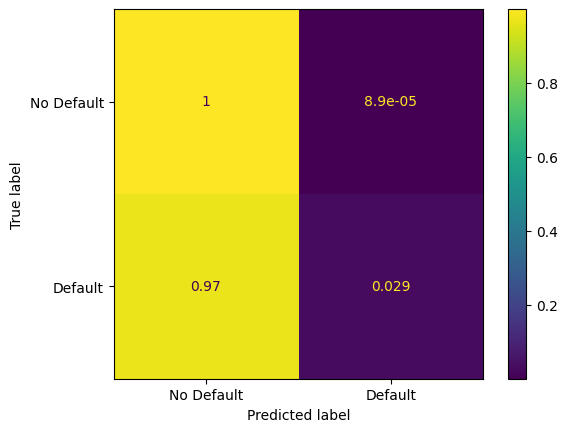

In [55]:
warnings.filterwarnings("ignore")
y_pred = model.predict(X_feats)
y_pred1 = [1 if num > 0.50 else 0 for num in y_pred]

target_names= ['No Default', 'Default']
matrix = confusion_matrix(y, y_pred1, normalize='true')
cm_display = ConfusionMatrixDisplay(confusion_matrix= matrix, display_labels=target_names).plot()

In [56]:
warnings.filterwarnings("ignore")
y_pred = model.predict(X_feats)
y_pred1 = [1 if num > 0.50 else 0 for num in y_pred]

target_names = ['No Default', 'Default']
matrix = confusion_matrix(y, y_pred1, normalize='true')
cm_display = ConfusionMatrixDisplay(confusion_matrix = matrix, display_labels = target_names).plot

In [57]:
print(classification_report(y, y_pred1, target_names = target_names))

              precision    recall  f1-score   support

  No Default       0.97      1.00      0.98   1478665
     Default       0.91      0.03      0.06     47994

    accuracy                           0.97   1526659
   macro avg       0.94      0.51      0.52   1526659
weighted avg       0.97      0.97      0.96   1526659



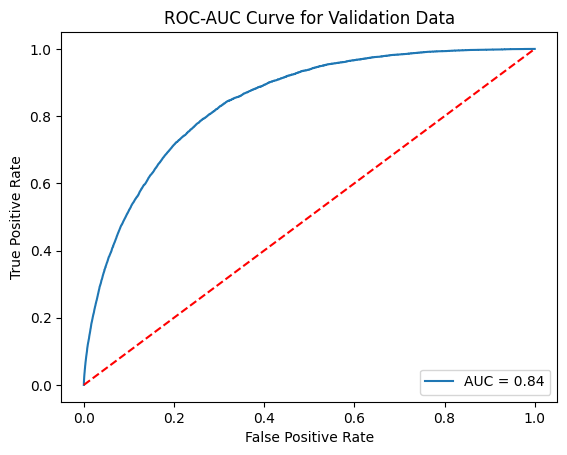

In [58]:
#ROC AUC для всех тренировочных данных

fpr, tpr, threshold = metrics.roc_curve(y_valid, y_pred_valid)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc = auc_score)
display.plot()
plt.plot([0,1], [0,1], 'r--')
plt.title('ROC-AUC Curve for Validation Data')
plt.show()

In [59]:
del y_pred, y_pred1
gc.collect()

4921

# Feature Importance

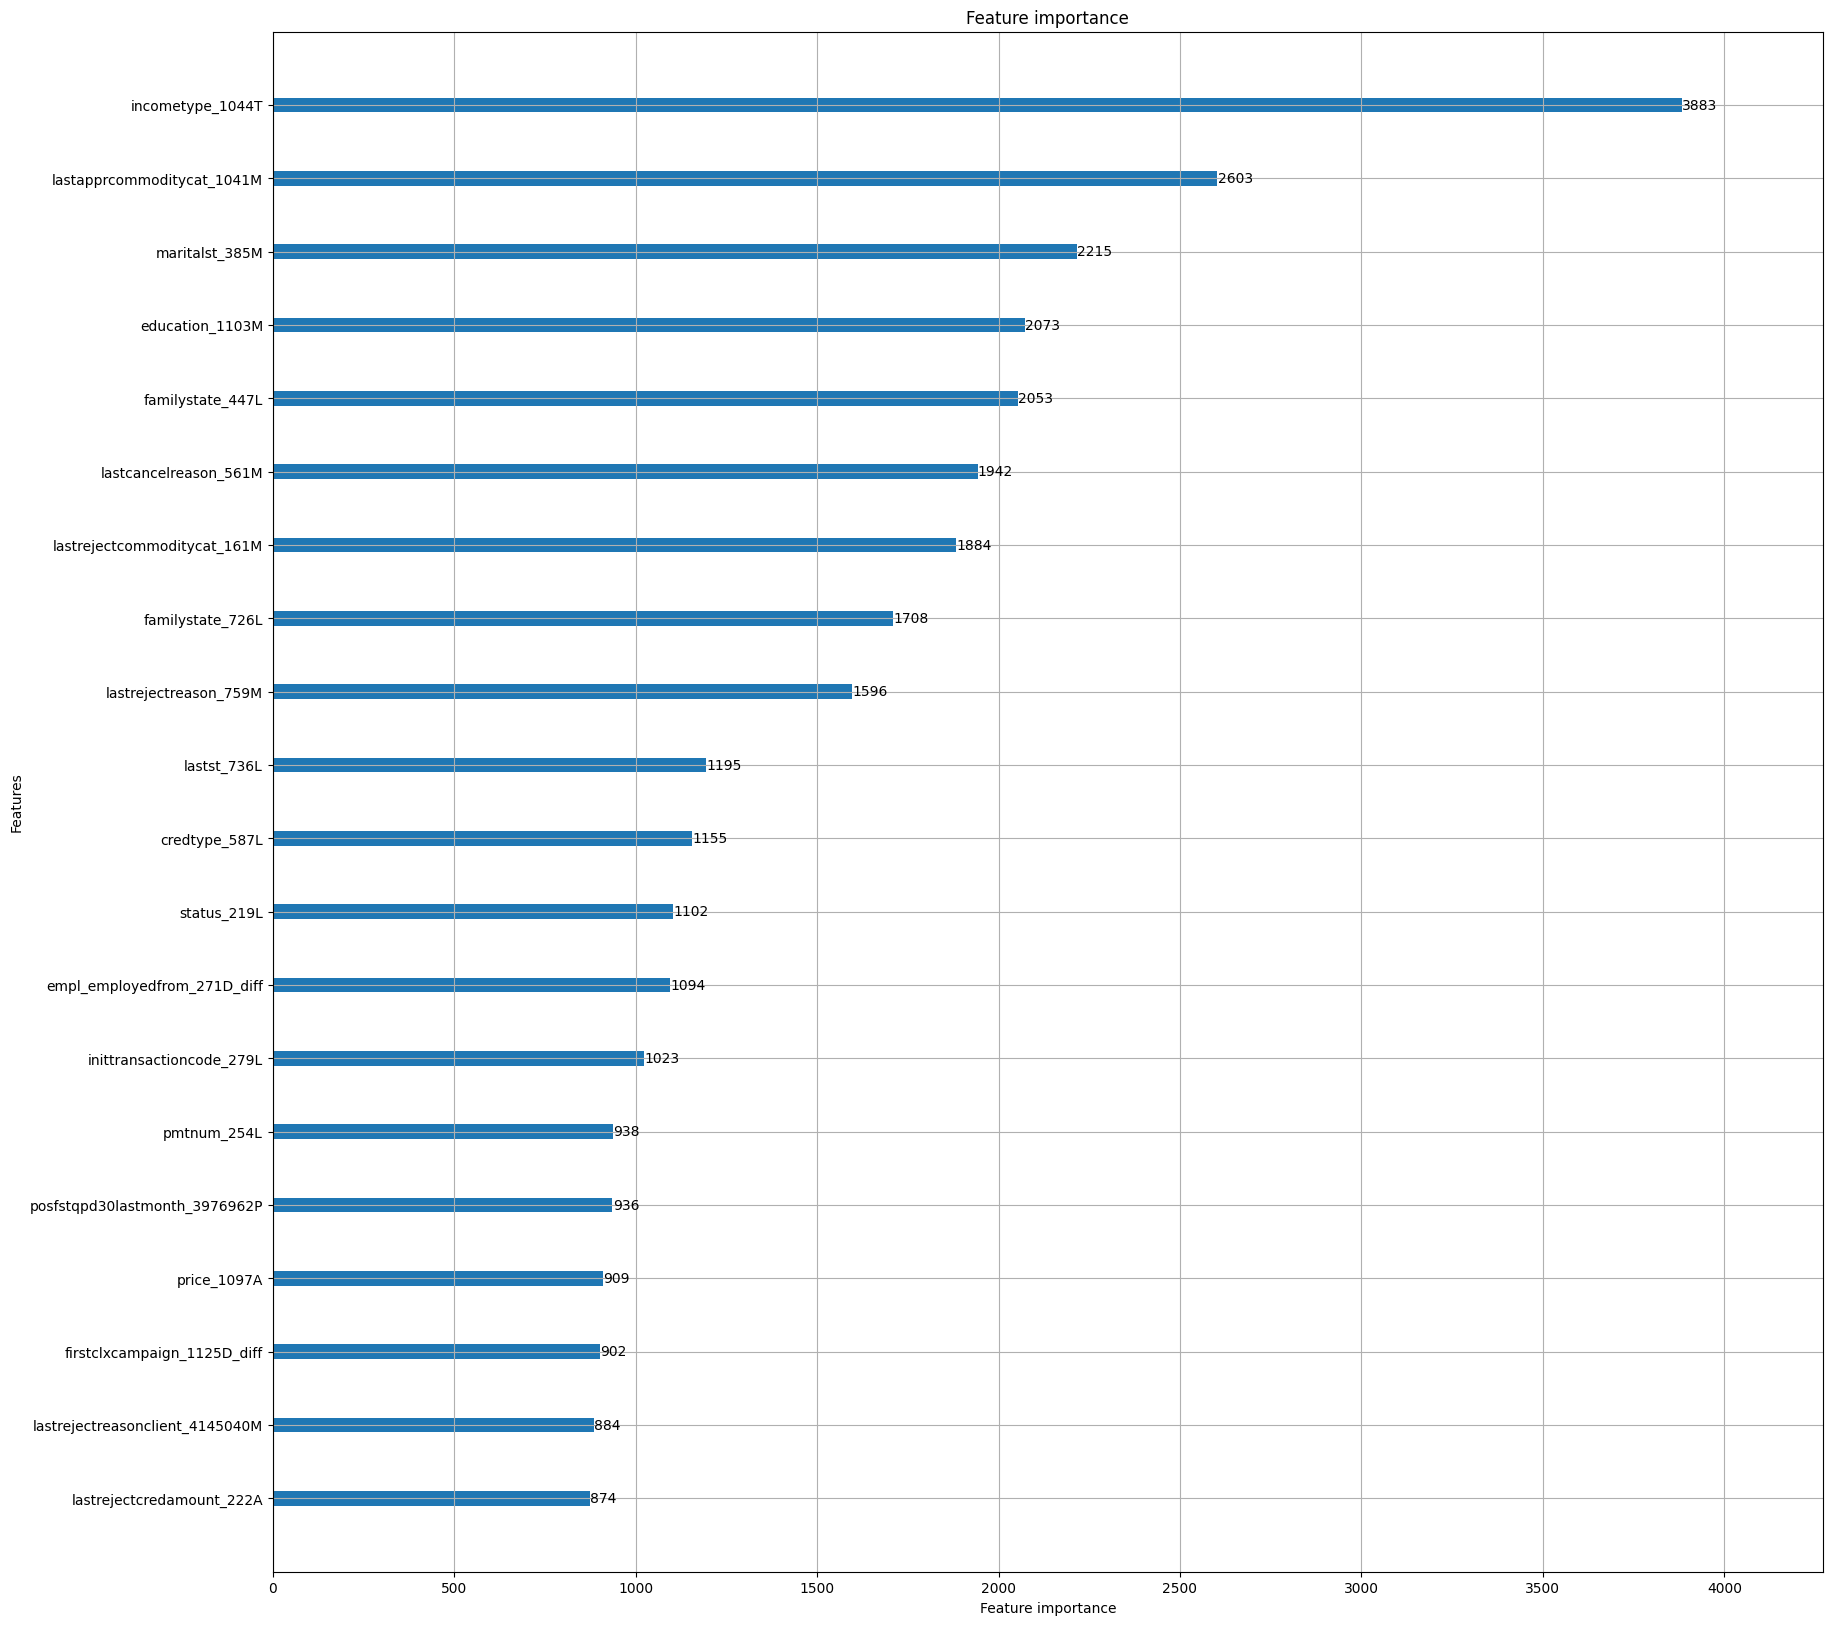

In [60]:
#Для модели LGB, ранжирование признаков по количеству сплитов

lgb.plot_importance(model_lgb, figsize=(20, 20), max_num_features = 20)
plt.show()

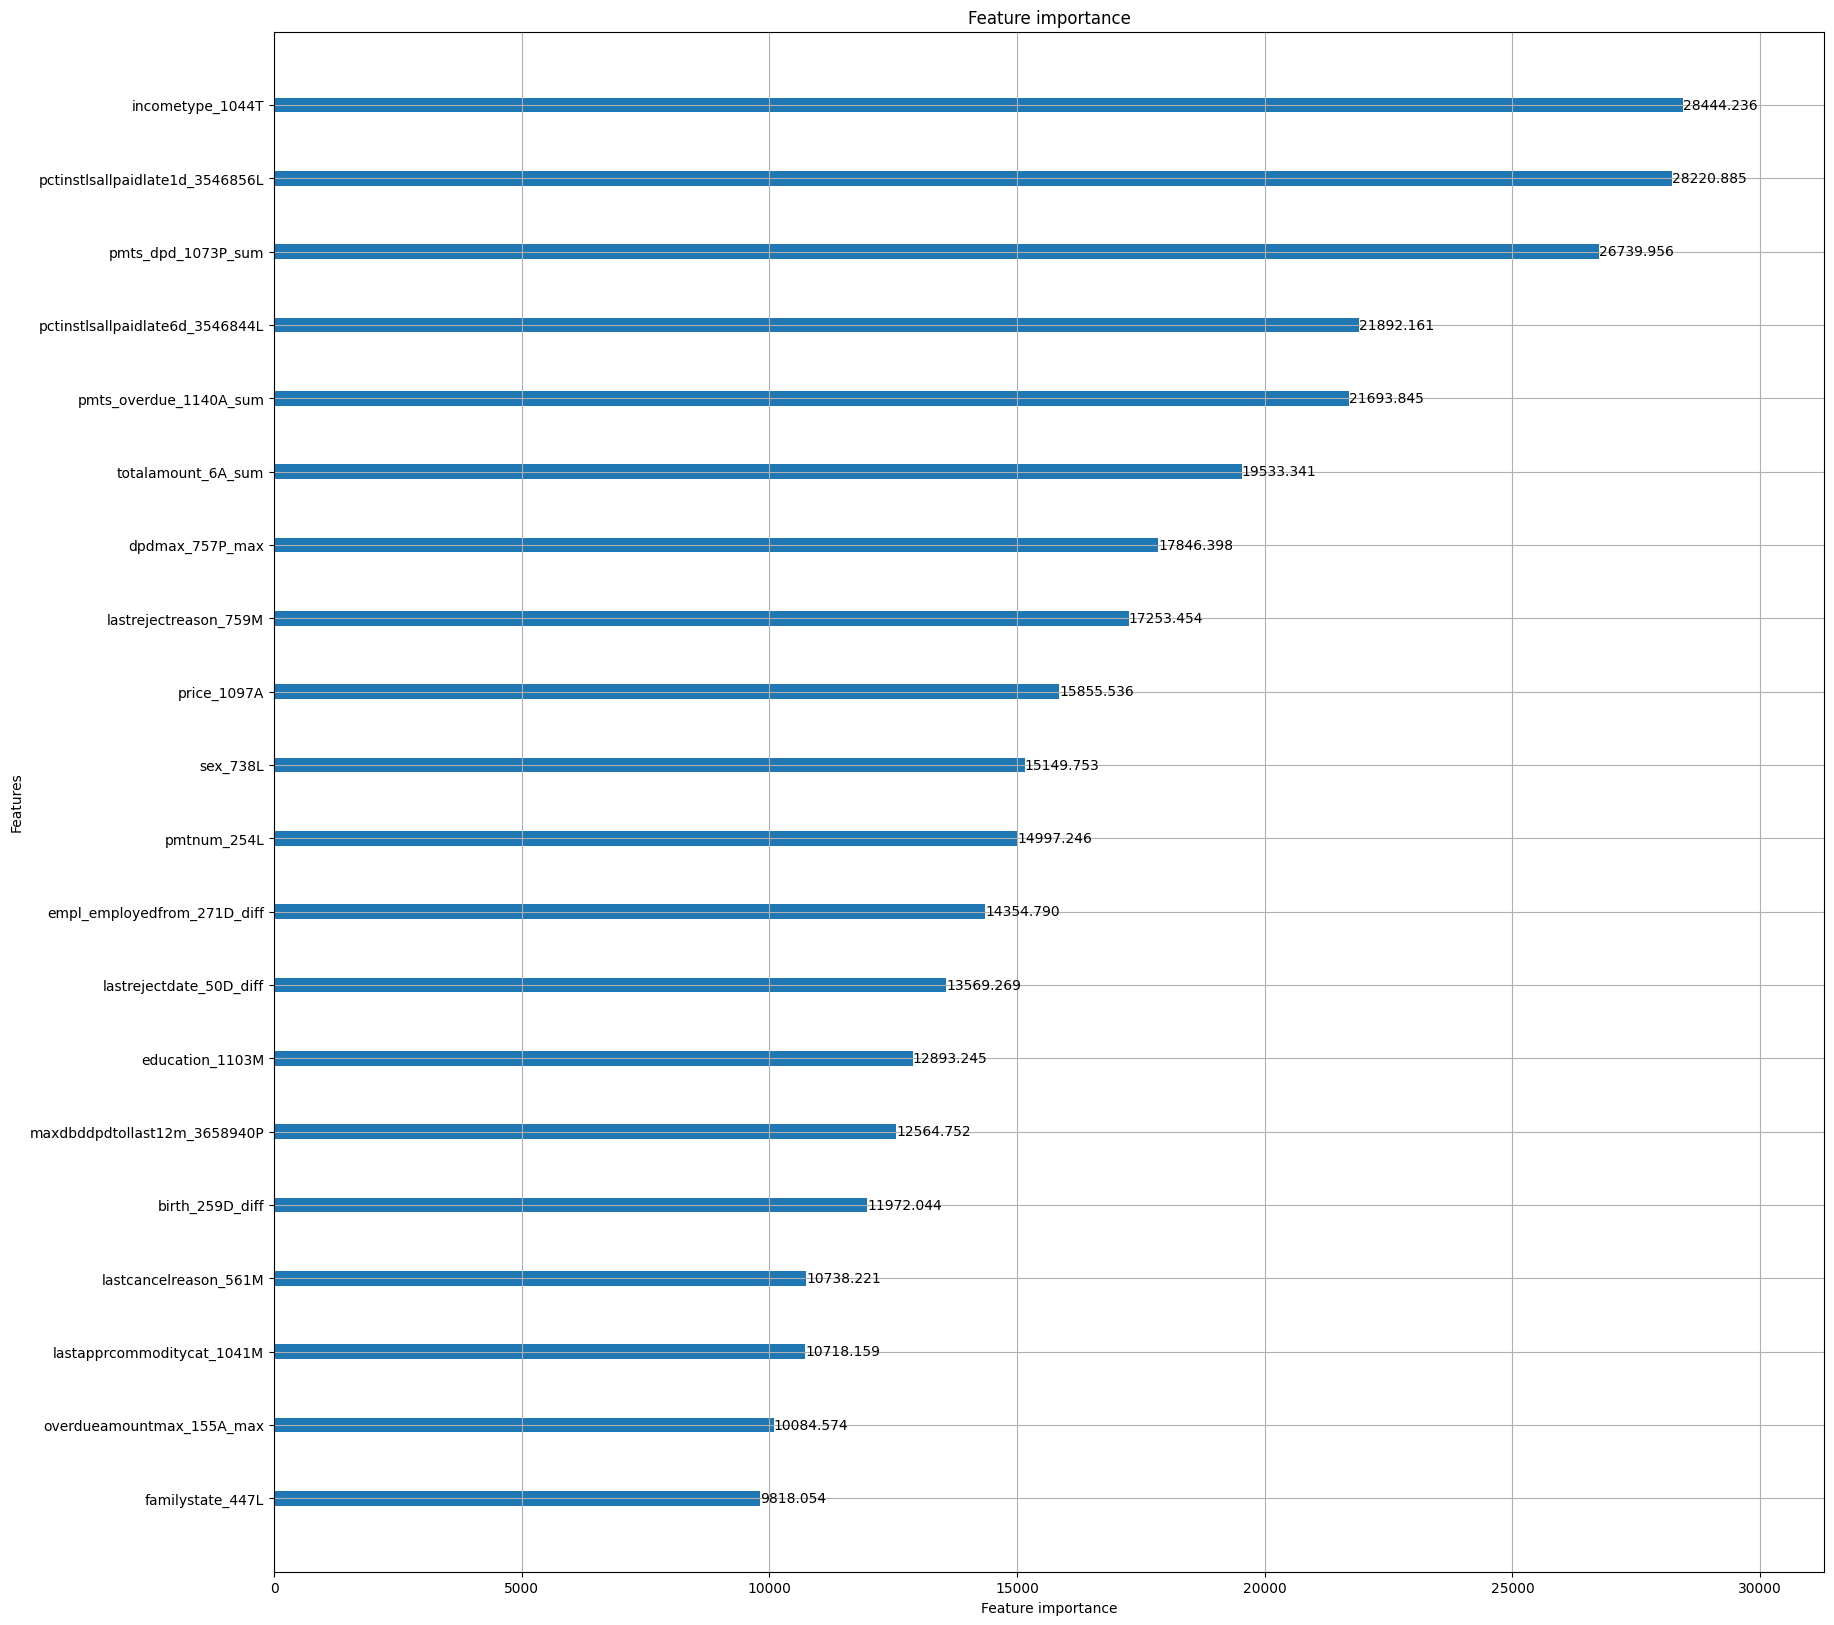

In [61]:
lgb.plot_importance(model_lgb, figsize=(20, 20), importance_type = 'gain', max_num_features = 20)
plt.show()

In [62]:
def plot_feature_importance(importance,columns,model_name):
    #Создание массивов для важных функций и имен функций
    feature_importance = np.array(importance)
    feature_names = np.array(columns)
    
    data = {'feature_names': feature_names, 'feature_importance': feature_importance}
    temp_df = pd.DataFrame(data)
    
    #сортировка df в порядке уменьшения значения признаков
    temp_df.sort_values(by=['feature_importance'], ascending=False, inplace=True)
    
    plt.figure(figsize=(20, 20))
    sns.barplot(x=temp_df['feature_importance'][:20], y=temp_df['feature_names'][:20])
    
    plt.title(model_name)
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Names')

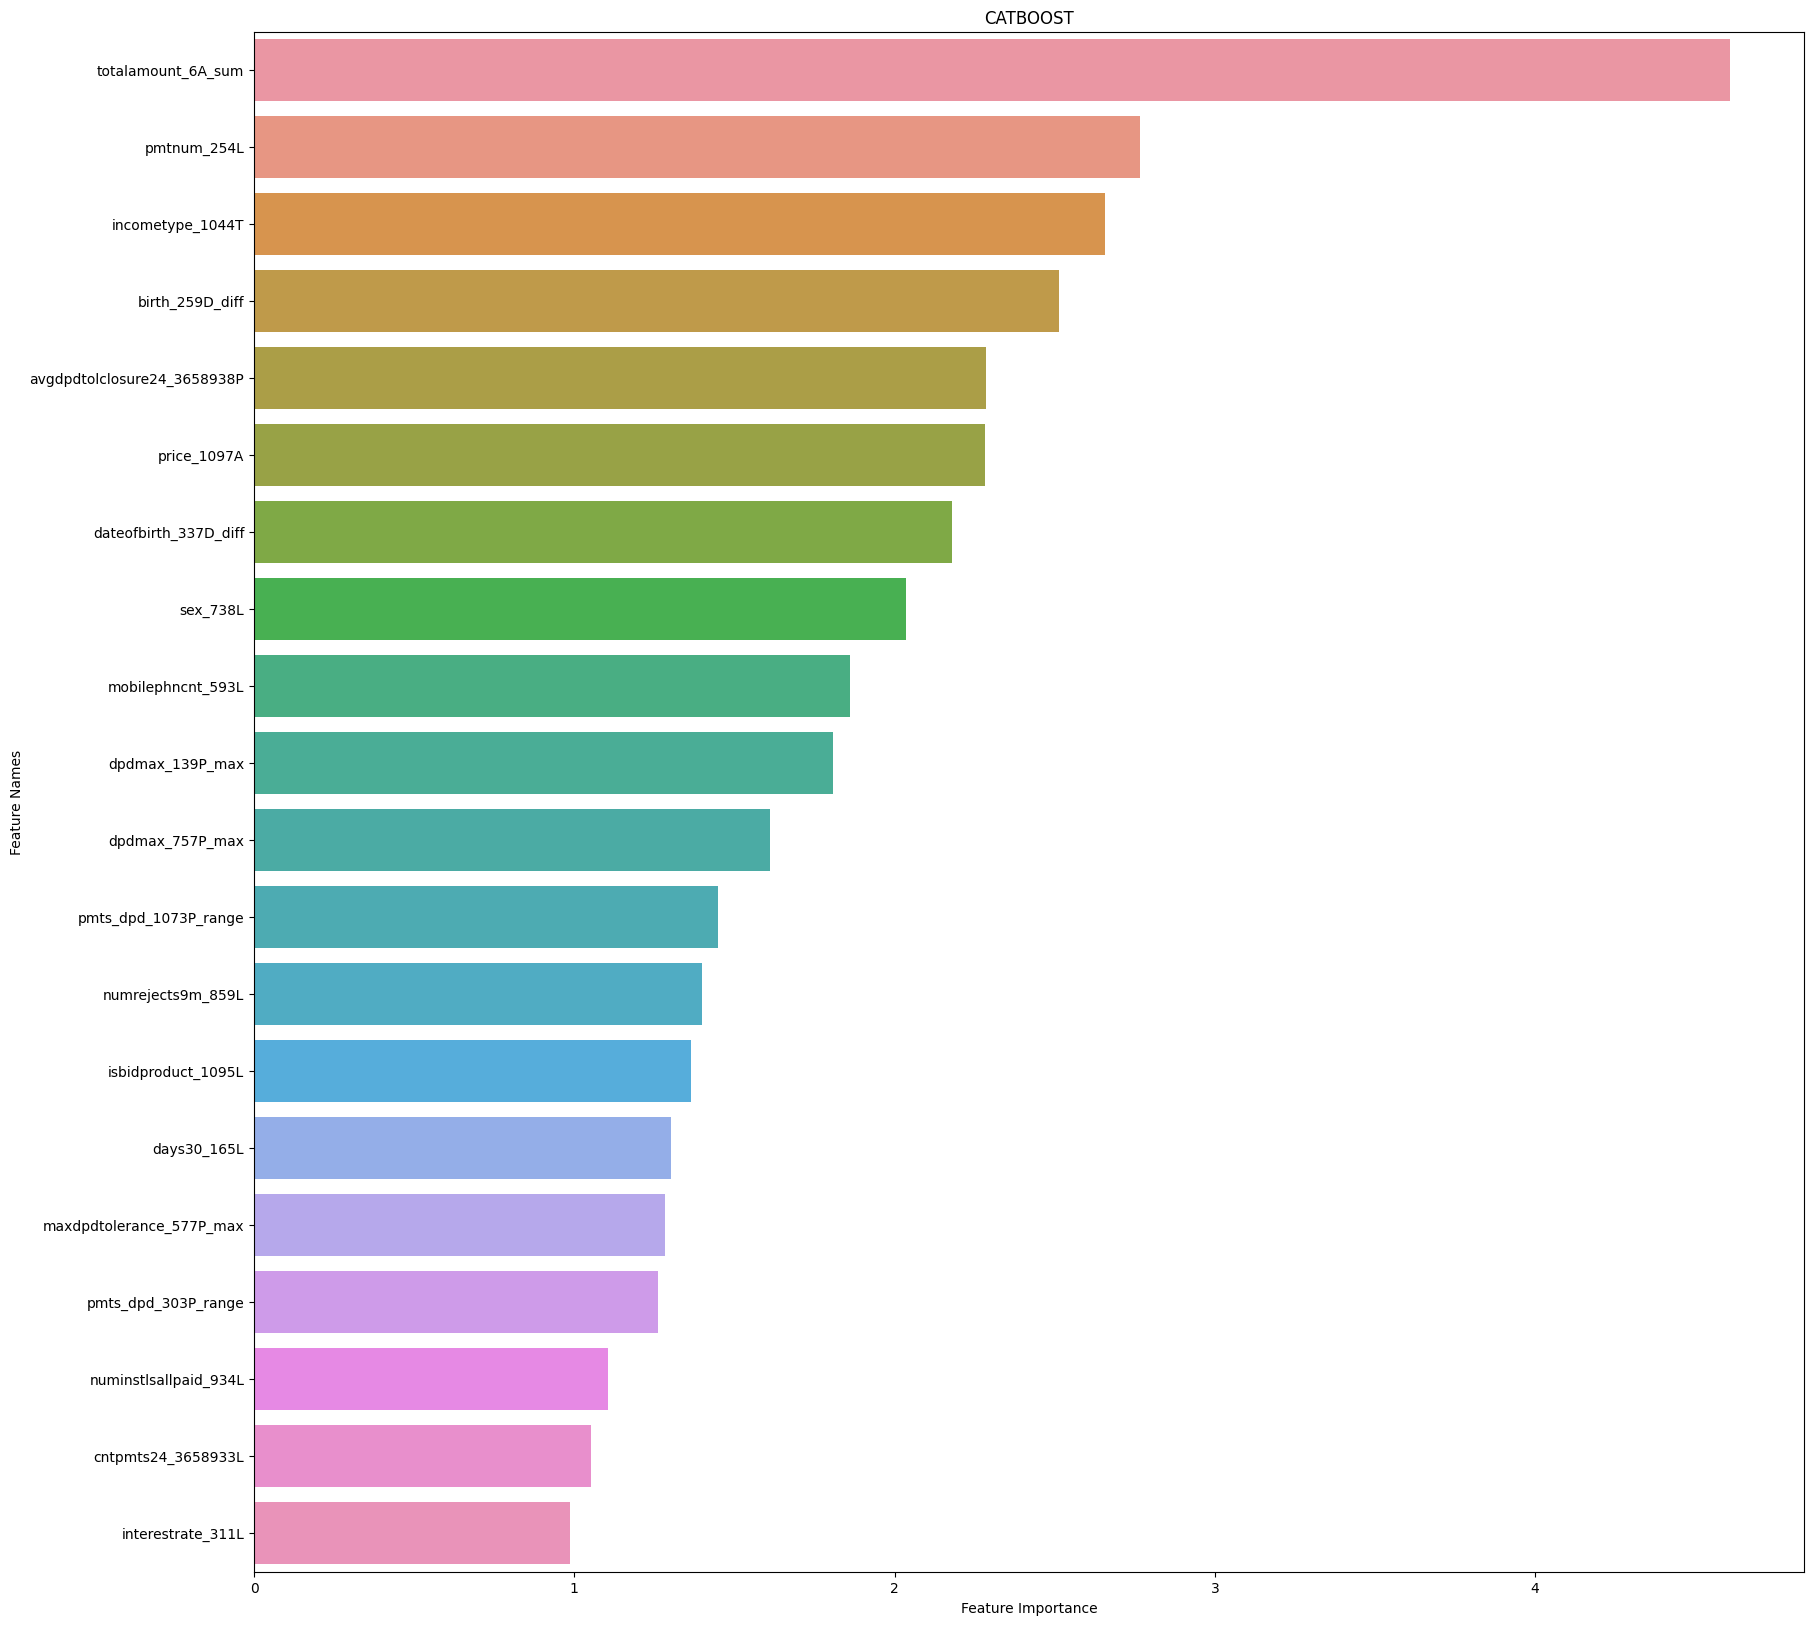

In [63]:
# вычисляет важность каждого признака путем сравнения производительности модели через get_feature_importance
#разница в функции потерь, получаемой при включении признака в отличие от его исключения. Чем больше разница, тем она важна.

plot_feature_importance(model_cat.get_feature_importance(type='PredictionValuesChange'), X_train.columns, "CATBOOST")
warnings.filterwarnings('default')

In [64]:
del X_feats, X_train, X_valid, y_train, y_valid, y
gc.collect()

21273

# Submission

In [65]:
# сортировка столбцов по алфавиту в соответствии с загруженной моделью

test = test.reindex(sorted(test.columns), axis=1)

predictions = model.predict_proba(test.drop(['case_id', 'WEEK_NUM'], axis=1))

In [66]:
print(predictions)

[[9.87025847e-01 1.29741534e-02]
 [9.78979645e-01 2.10203555e-02]
 [9.99046154e-01 9.53846085e-04]
 [9.92072015e-01 7.92798514e-03]
 [8.76504384e-01 1.23495616e-01]
 [9.96051644e-01 3.94835577e-03]
 [9.68649250e-01 3.13507503e-02]
 [9.95887254e-01 4.11274628e-03]
 [9.86678154e-01 1.33218457e-02]
 [9.75875744e-01 2.41242562e-02]]


In [67]:
del test
gc.collect()

4

In [68]:
submission = pd.DataFrame({'case_id': ids, 'score': predictions[:, 1]}).set_index('case_id')
submission

,score
case_id,
57543,0.012974
57549,0.021020
57551,0.000954
57552,0.007928
57569,0.123496
57630,0.003948
57631,0.031351
57632,0.004113
57633,0.013322


In [69]:
submission.to_csv("./submission.csv")